## Import Libraries

In [1]:
from fastai.vision import *
from fastai import *
from fastai.data_block import *

from pathlib import Path

from unet import VolumetricUnet, dice_loss, dice_score, predict, plot_predictions, eval_preds, Transformer

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import FloatTensor as FT

import sys
sys.path.extend(['../'])
from Vent_Seg_Preprocessing.helper import normalize, extract_brain

## Choose GPU

In [2]:
torch.cuda.set_device(3)

## Load Data


In [3]:
data_path = Path("/data/public/Segmentation_Dataset/CT_Dataset")
trn_img = sorted(list(Path(data_path/"train/skull_stripped").iterdir()))
trn_mask = sorted(list(Path(data_path/"train/ventricle_masks").iterdir()))
valid_img = sorted(list(Path(data_path/"validation/skull_stripped").iterdir()))
valid_mask = sorted(list(Path(data_path/"validation/ventricle_masks").iterdir()))
test1_img = sorted(list(Path(data_path/"test1/skull_stripped_pred").iterdir()))
test1_mask = sorted(list(Path(data_path/"test1/ventricle_masks").iterdir()))
test2_img = sorted(list(Path(data_path/"test2/skull_stripped_pred").iterdir()))
test2_mask = sorted(list(Path(data_path/"test2/ventricle_masks").iterdir()))

In [4]:
print(f"Size of Train Dataset: {len(trn_img)} Images")
print(f"Size of Validation Dataset: {len(valid_img)} Images")
print(f"Size of Test 1 Dataset: {len(test1_img)} Images")
print(f"Size of Test 2 Dataset: {len(test2_img)} Images")

Size of Train Dataset: 107 Images
Size of Validation Dataset: 26 Images
Size of Test 1 Dataset: 9 Images
Size of Test 2 Dataset: 18 Images


## Create Databunch for train, validation, and both test sets

The training dataset undergoes data augmentation. There are two types used during the training:
* Rotation
* Zoom with center crop to maintain 128x256x256 shape

Both operations are applied randomly with probability of 0.4 and separately from each other. The motivation for using data augmentation, especially zoom, is to increase representation of enlarged ventricles in the training dataset. Though these ventricles are less common, it is important to be able to segment them accurately and detect volumetric change in ventricles.

In [5]:
# Apply 15 degree rotation with probability of 0.4
# The deafult zooming-in factor is 1.3 and is done along x and y axis with probability 0.4
transformer = Transformer(15, 0.4)

In [6]:
class CT_3D_Dataset(object):
    def __init__(self, images, ventricles, transform=None):
        self.images = images
        self.ventricles = ventricles
        self.transform = transform
    
    def __getitem__(self, index):
        image_voxel = np.load(self.images[index]).astype(np.float32)
        mask_voxel = np.load(self.ventricles[index]).astype(np.float32)
        if self.transform:
            image_voxel, mask_voxel = self.transform(image_voxel, mask_voxel)
        return FT(image_voxel[None,:]), FT(mask_voxel) 

    def __len__(self):
        return len(self.images)
    
train_ds = CT_3D_Dataset(trn_img, trn_mask, transform=transformer.transform)
valid_ds = CT_3D_Dataset(valid_img, valid_mask)
test1_ds = CT_3D_Dataset(test1_img, test1_mask)
test2_ds = CT_3D_Dataset(test2_img, test2_mask)

data = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, bs=3)

## Import Unet architecture

In [7]:
unet = VolumetricUnet(in_channel=1, out_channel=4, num_classes=1)

## Create Fastai Learner


Source: https://docs.fast.ai/basic_train.html#Learner

The Learner object has default weight decay of 0.01 and uses the Adam Optimizer

In [8]:
learner = Learner(data=data, model=unet)

In [9]:
# Use Dice Loss for loss function for training
# Evaluate validation set using dice score at threshold of 0.5
learner.loss_func = dice_loss
learner.metrics = [dice_score]

In [10]:
learner.to_fp16();

## Load model weights trained from MR ATLAS masks

In [11]:
learner.load('DL_Ventricle_MR_ATLAS_5_epochs_3e-2_lr');

The below code creates layer groups. Of the 8 total layer groups, the parameters of the first seven layers (the first half or encoder of the U-Net) are frozen and the second half of the U-Net is initially trained with differential learning rates. The purpose of doing this to perform tranfer learning and fine tune on hand drawn MR ventricle masks to better learn human level segmentation ability. 

In [12]:
learner.split([learner.layer_groups[0][0:3], 
                learner.layer_groups[0][3:7],
                learner.layer_groups[0][7:10],
                learner.layer_groups[0][10:13], 
                learner.layer_groups[0][13:16],
                learner.layer_groups[0][16:19], 
                learner.layer_groups[0][19:22],
                learner.layer_groups[0][22:]
               ])

In [13]:
learner.freeze()

## Apply Learning Rate Finder

See https://docs.fast.ai/basic_train.html#lr_find

Explores learning rates from 10e-7 to 10 over a 100 iterations. It stops when loss diverges.

This technique is discussed in Cyclical Learning Rates for Training Neural Networks  (https://arxiv.org/pdf/1803.09820.pdf).

In [14]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


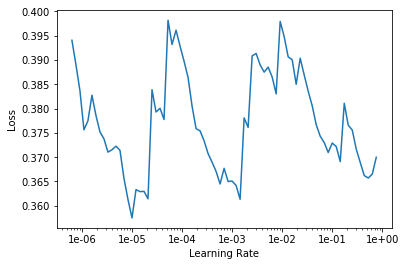

In [16]:
learner.recorder.plot()

## Fit Model with Cyclical Learning Rates

See https://docs.fast.ai/train.html#fit_one_cycle for more info
From documentation: 

Manage 1-Cycle style training as outlined in Leslie Smith's paper (https://arxiv.org/pdf/1803.09820.pdf). According to the abstract, the purpose of this technique is to speed up model training

lr_max for each layer is picked with the lr_find test. In phase 1, the learning rates goes from lr_max/div_factor (div factor being 25.0 by default) to lr_max linearly while the momentum goes from momentum (0.95) to momentum (0.85) linearly. In phase 2, the learning rates follows a cosine annealing from lr_max to 0, as the momentum goes from 0.95 to momentum 0.80 with the same annealing.

In [14]:
learner.fit_one_cycle(5, 5e-2)

epoch,train_loss,valid_loss,dice_score
1,0.353347,0.230068,0.771382
2,0.322579,0.508255,0.491771
3,0.321550,0.236573,0.764432
4,0.305759,0.223403,0.777268
5,0.288661,0.220390,0.780438


In [15]:
learner.save("DL_Ventricles_TL_CT_5_epochs_5e-2")

### Unfreeze all layers and make all parameters able to be updated via back prop and gradient descent

Reapply learning rate finder to find range of suitable learning rates for a model where all parameters can be updated

In [16]:
learner.load("DL_Ventricles_TL_CT_5_epochs_5e-2");

In [17]:
learner.unfreeze()

In [18]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


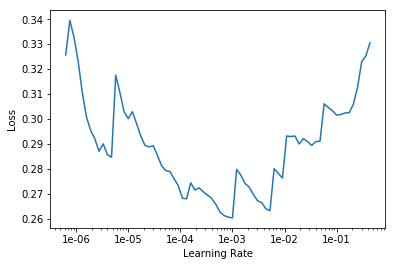

In [19]:
learner.recorder.plot()

### Reapply cyclical learning rate training to unfrozen model

In [20]:
learner.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,dice_score
1,0.289383,0.215755,0.784832
2,0.277650,0.220427,0.780208
3,0.275701,0.214456,0.786226
4,0.269742,0.213868,0.786910
5,0.272297,0.212591,0.788124


In [21]:
#learner.save("DL_Ventricles_TL_CT_5_epochs_5e-2_5_epochs_3e-3");

## Inspect Predictions on Validation Set

In [ ]:
learner.load("DL_Ventricles_TL_CT_5_epochs_5e-2_5_epochs_3e-3");

In [11]:
images, preds, masks = predict(learner, data)

In [16]:
IMG_NUM = 5
image = images[IMG_NUM]
pred = preds[IMG_NUM]
mask = masks[IMG_NUM]

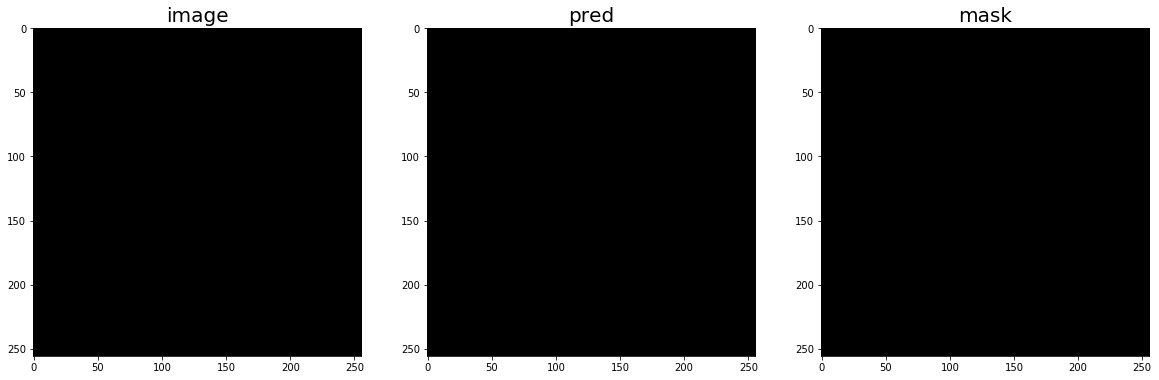

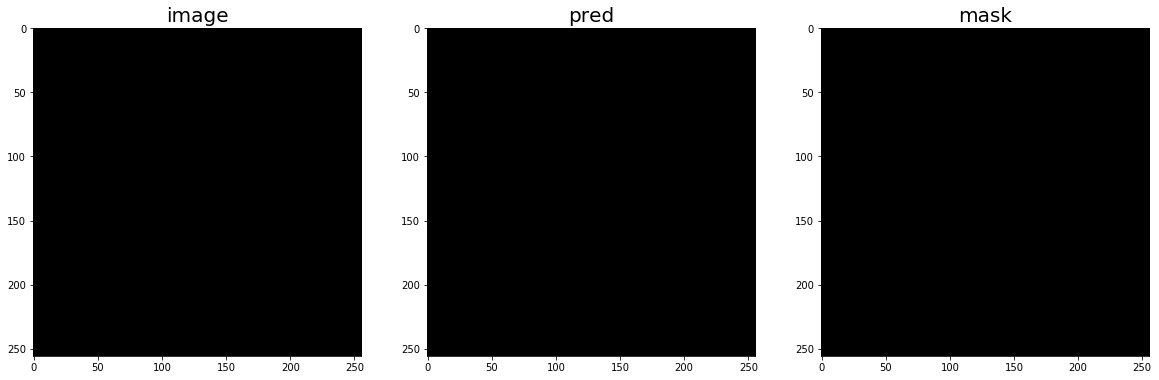

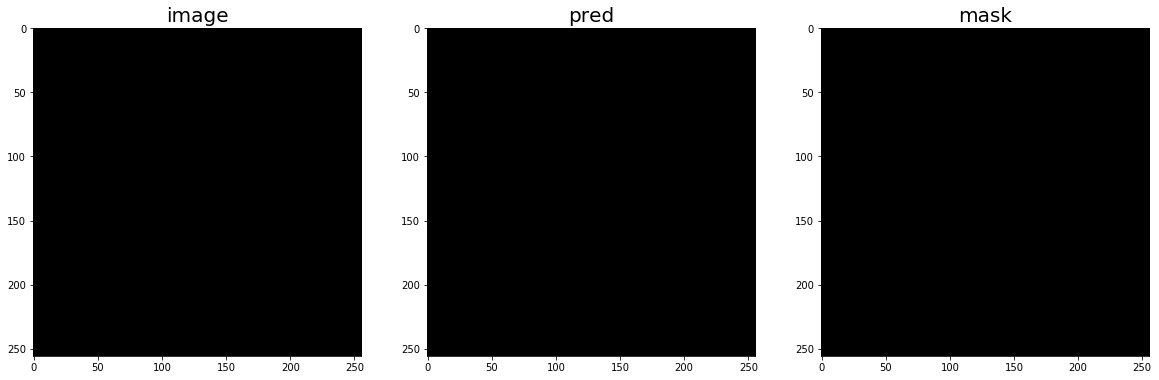

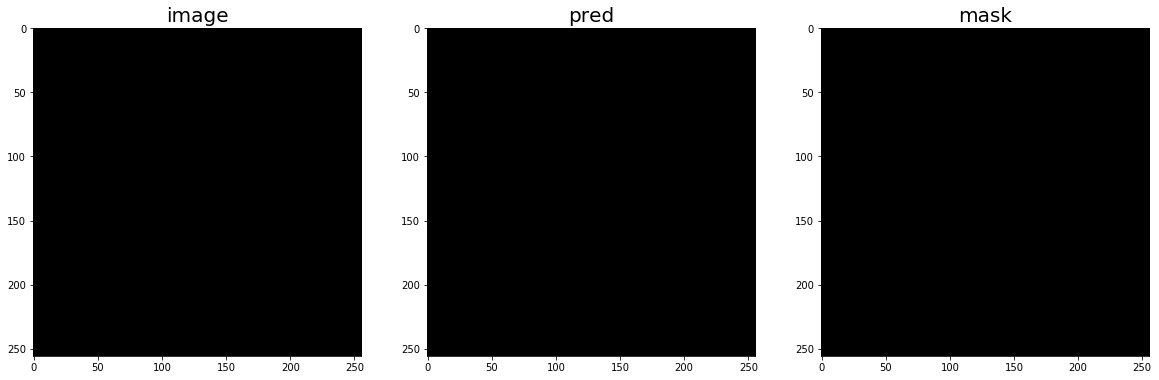

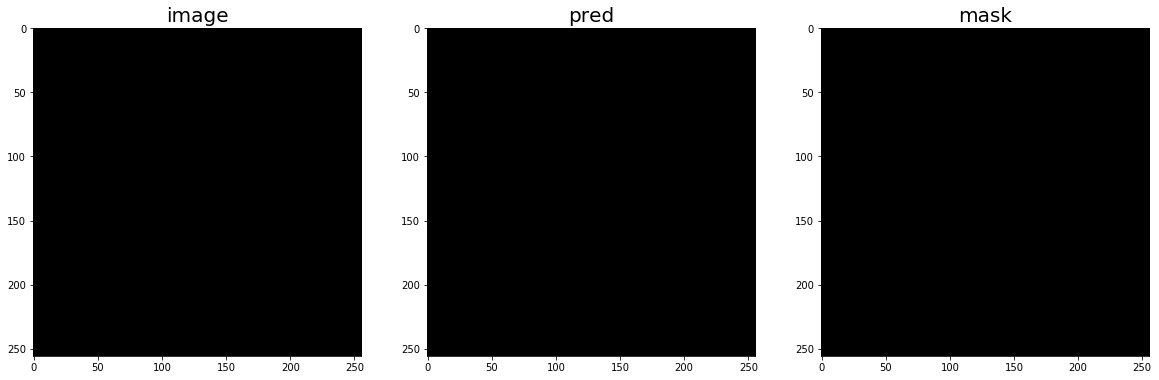

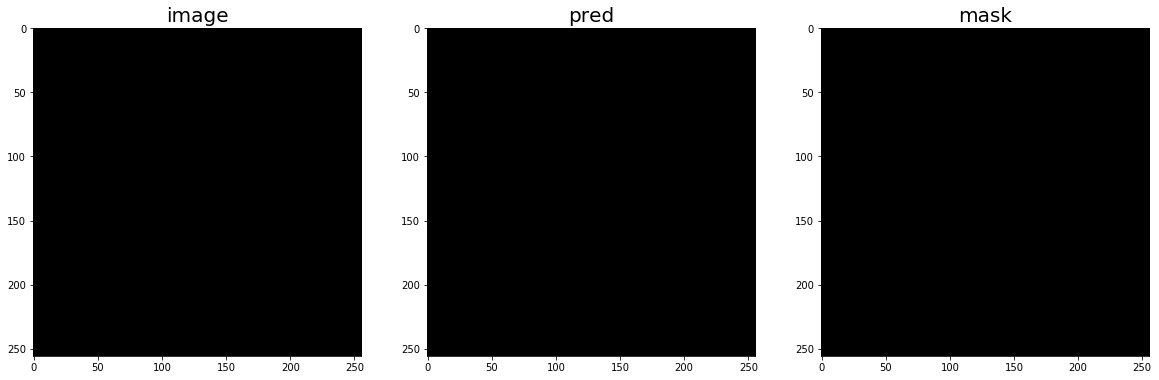

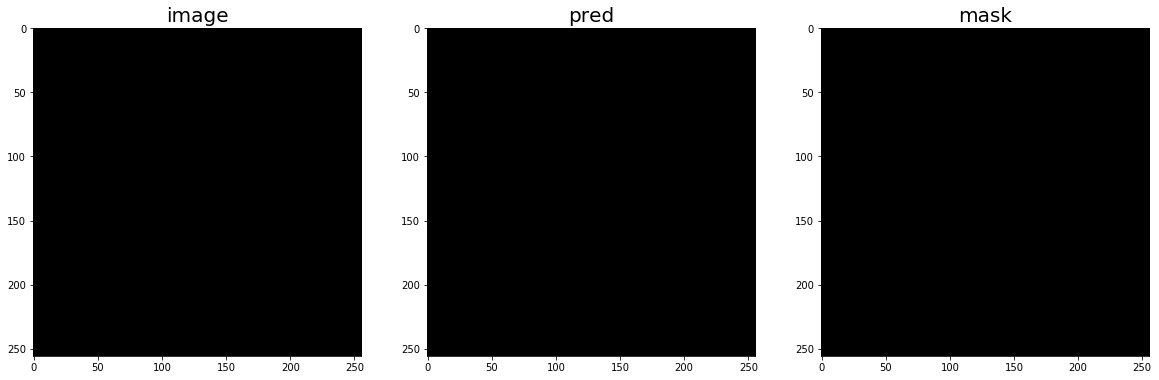

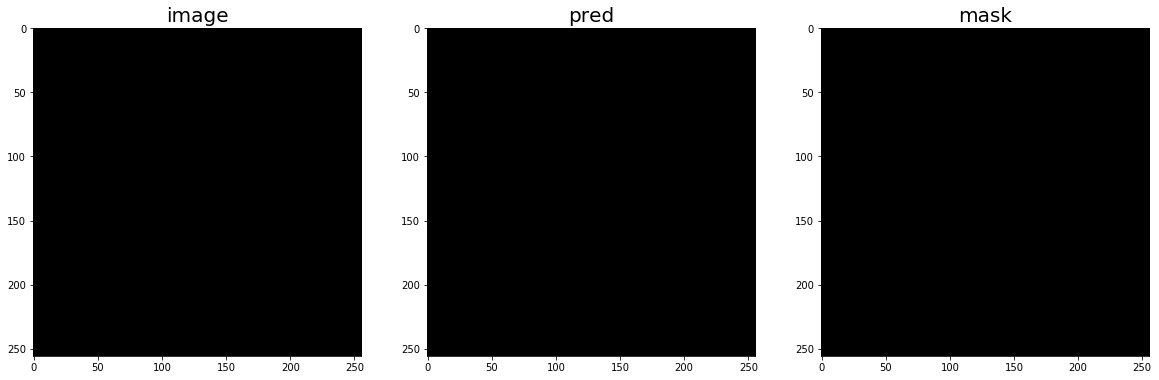

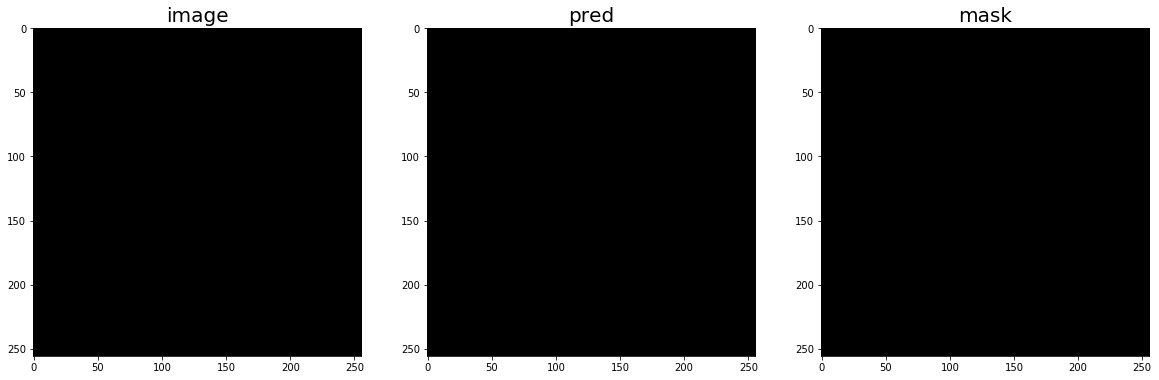

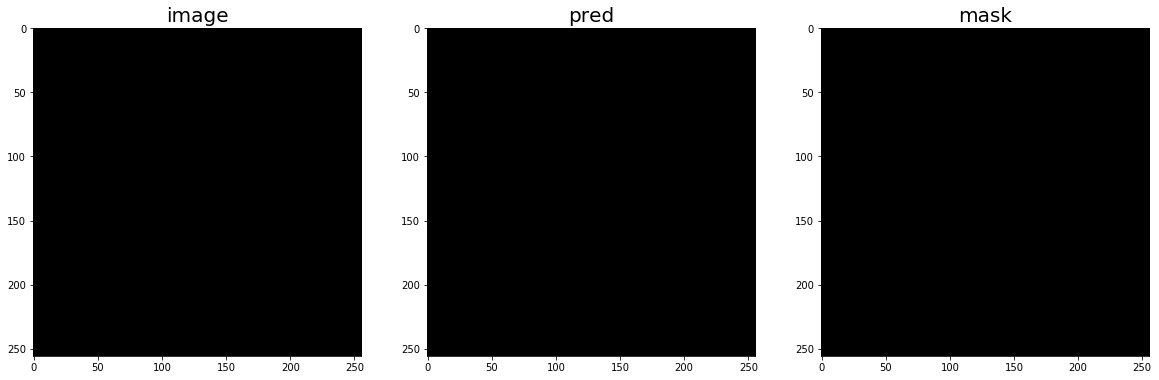

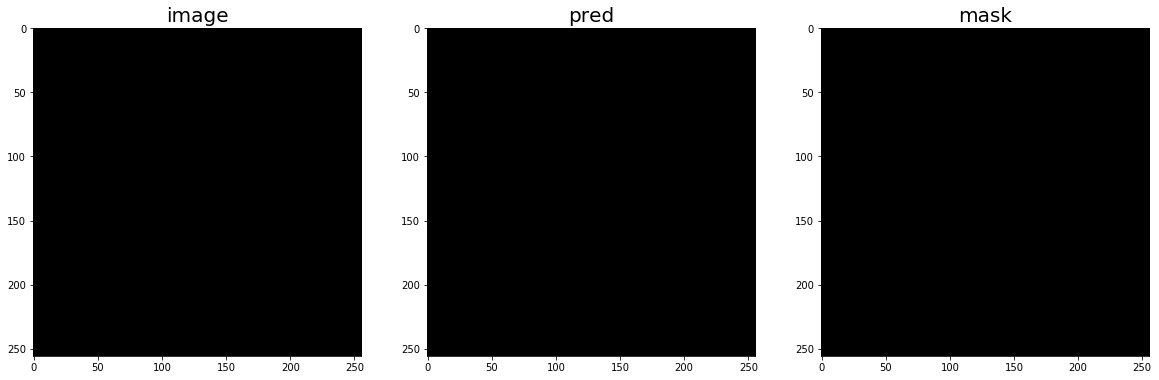

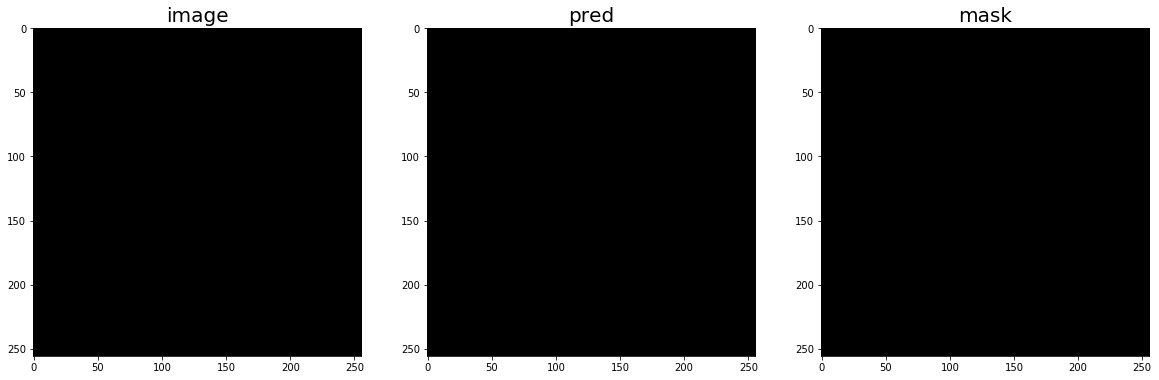

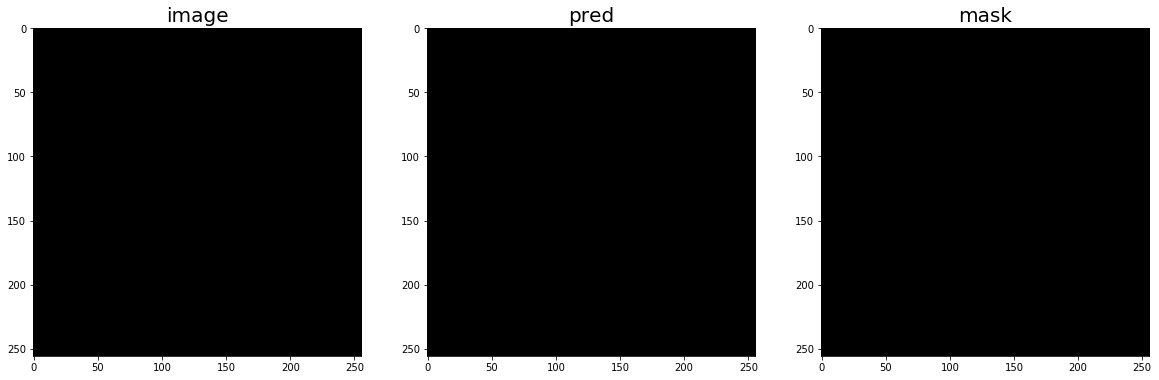

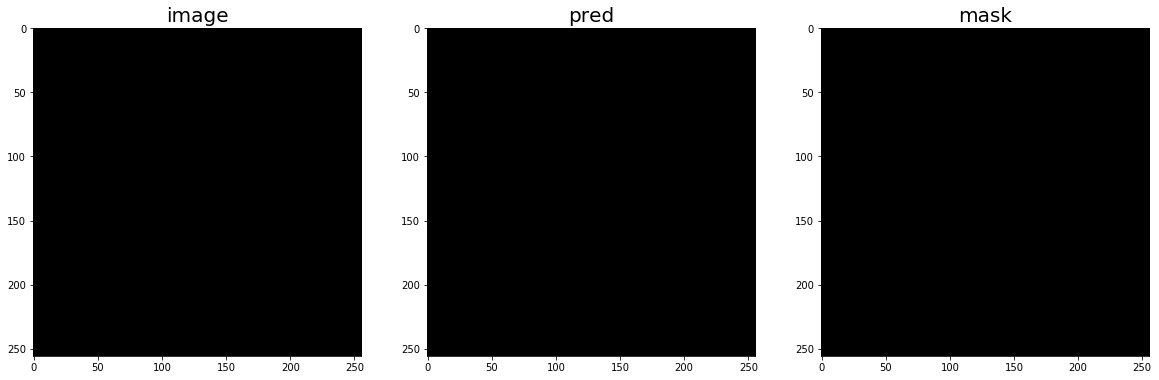

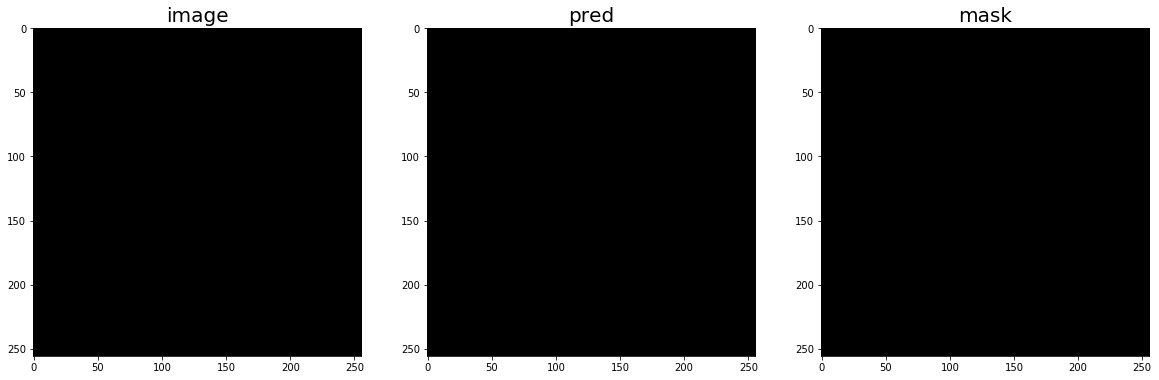

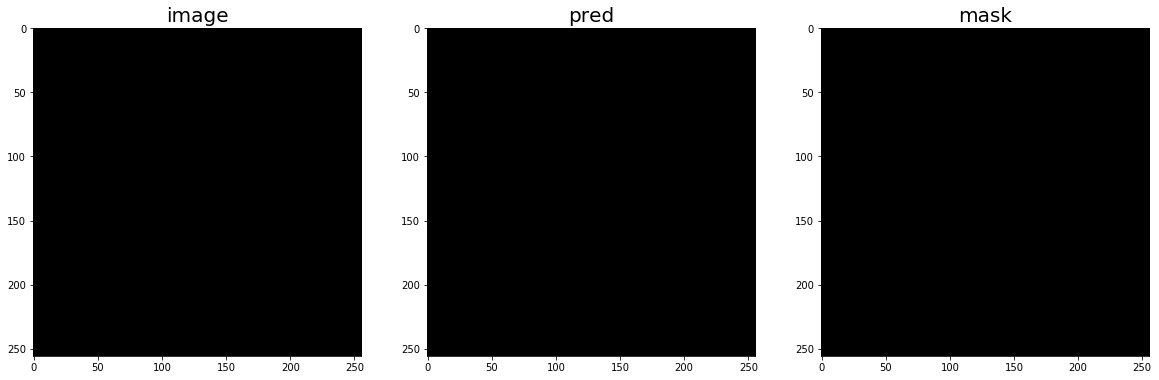

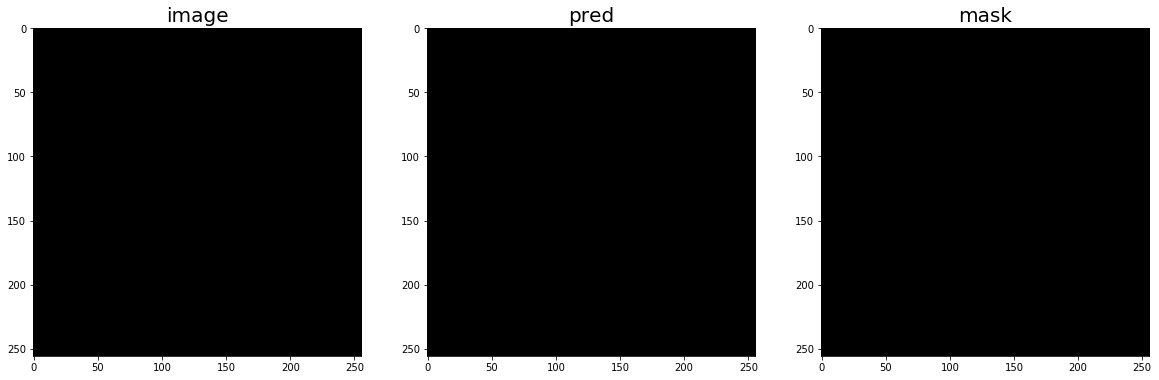

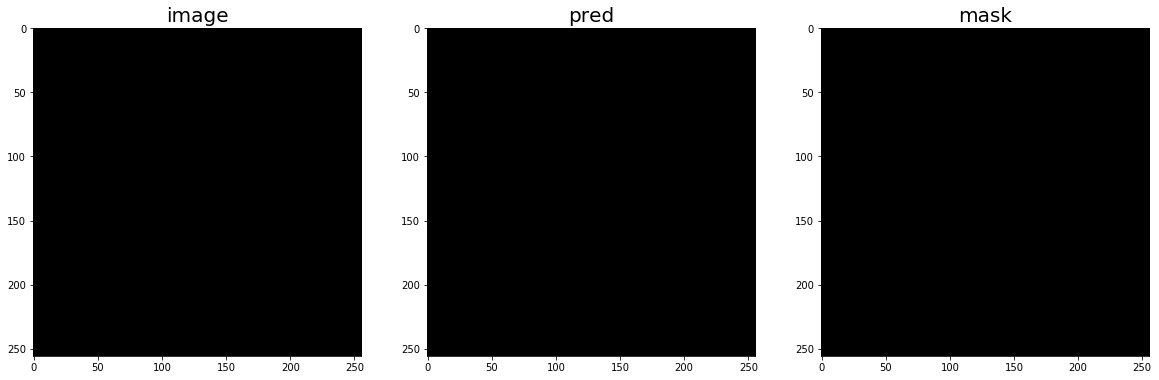

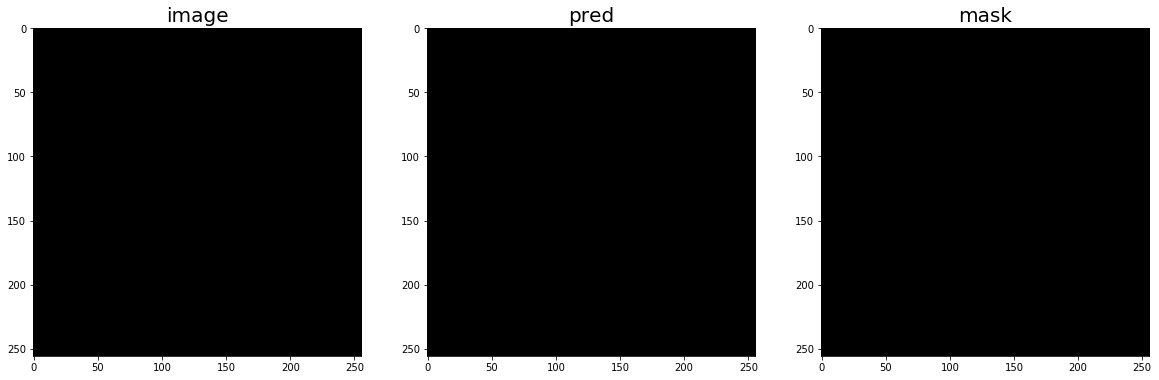

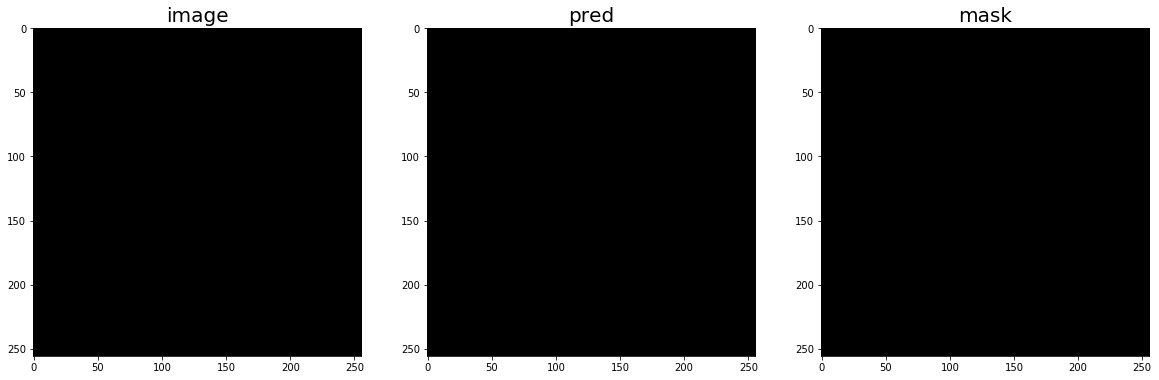

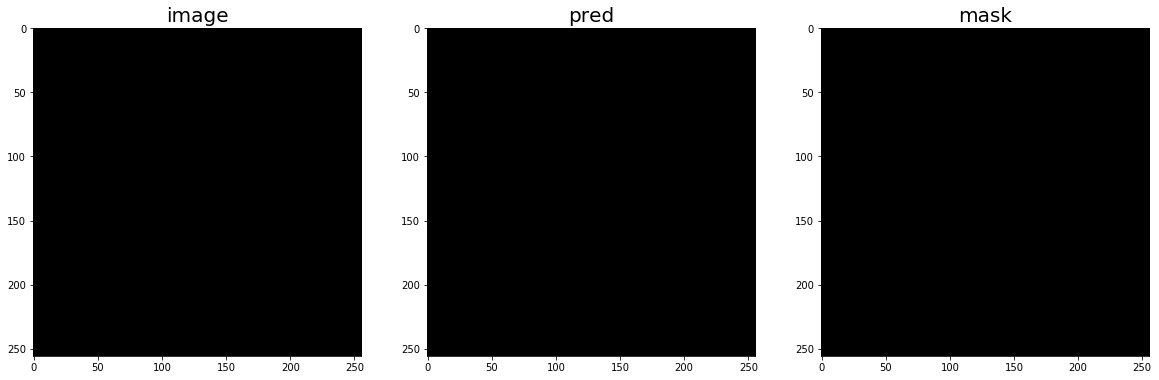

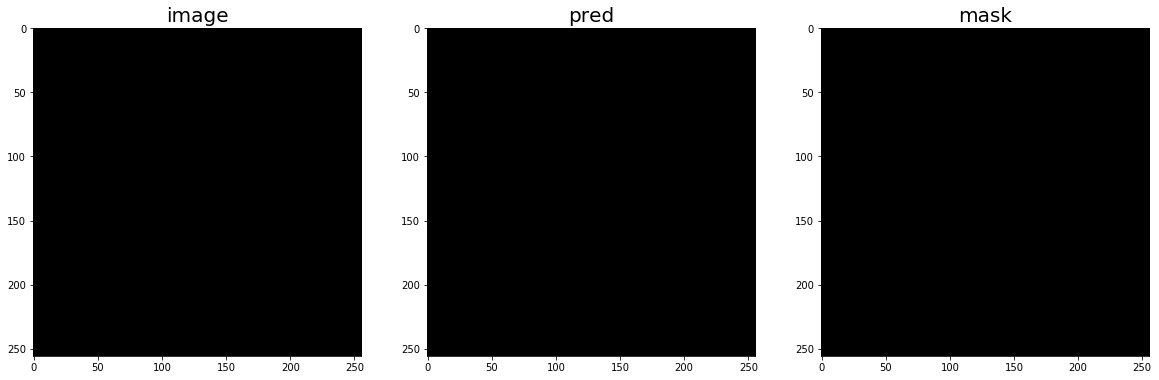

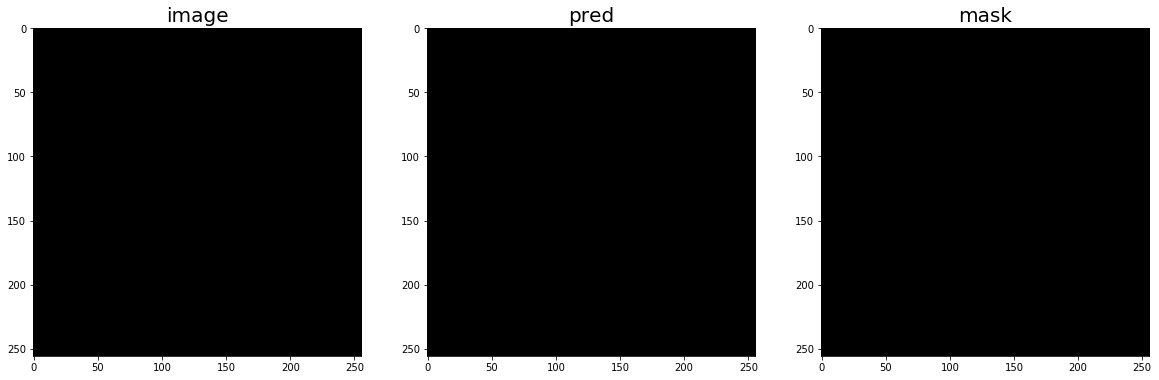

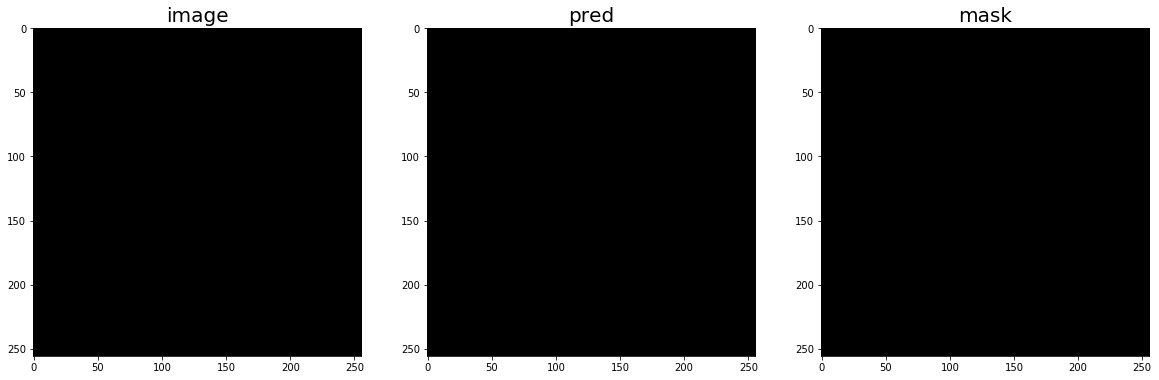

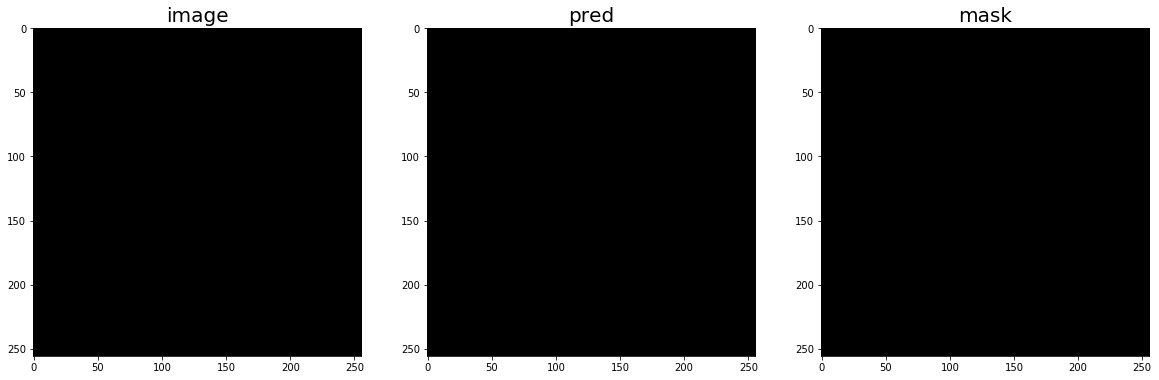

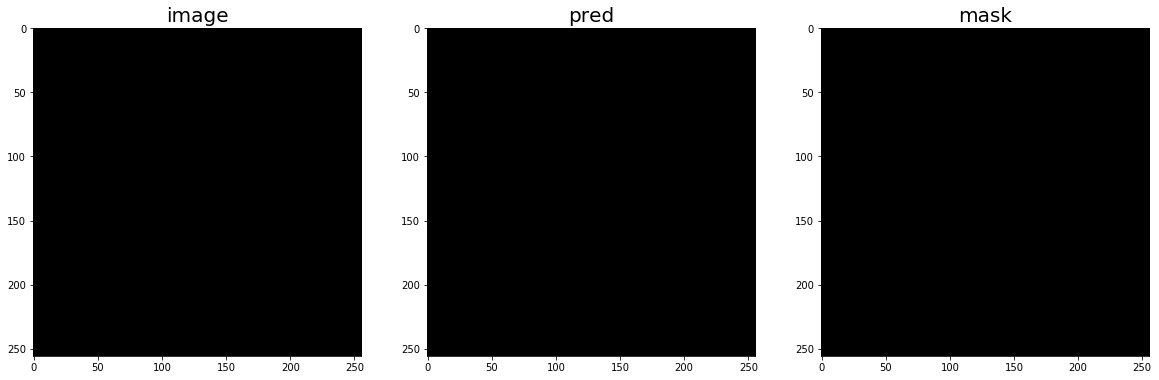

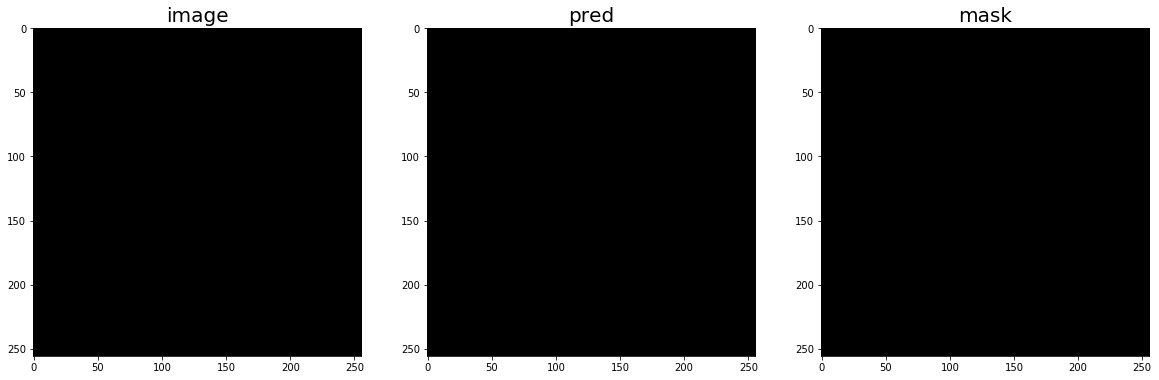

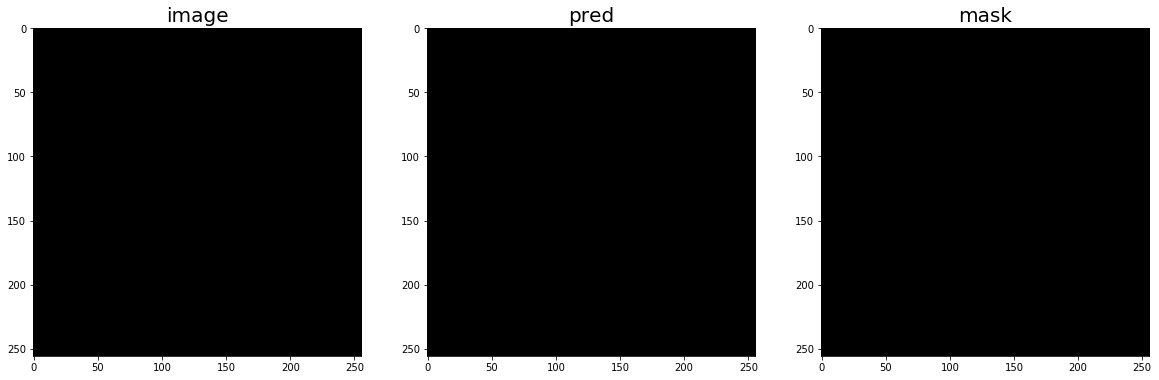

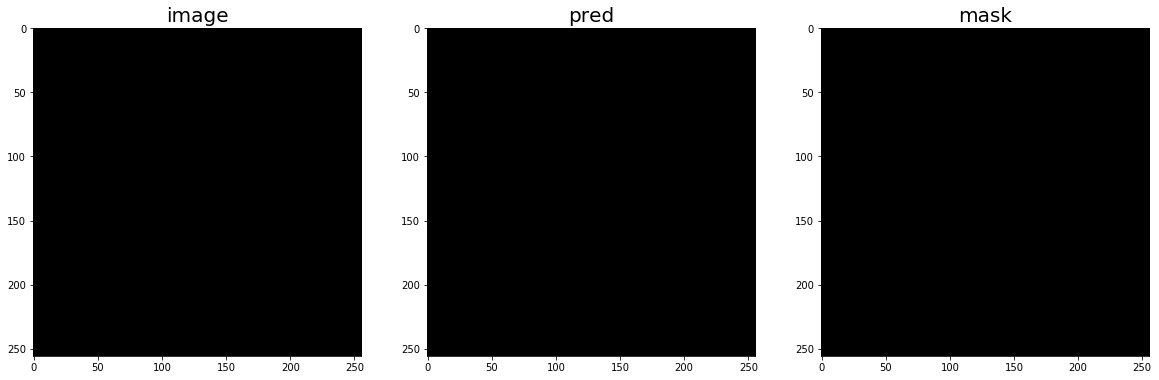

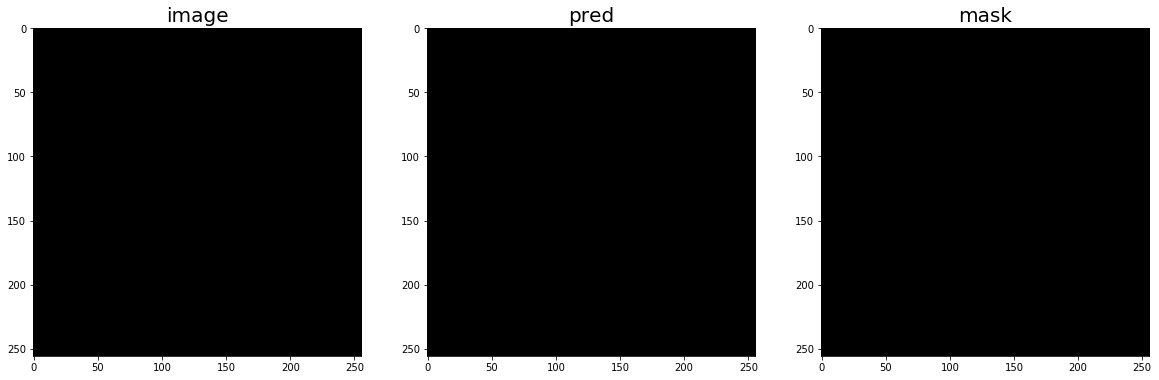

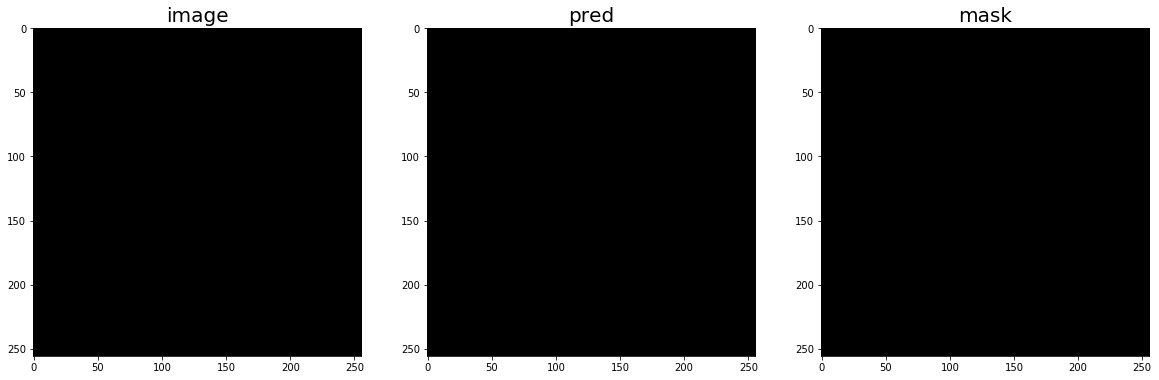

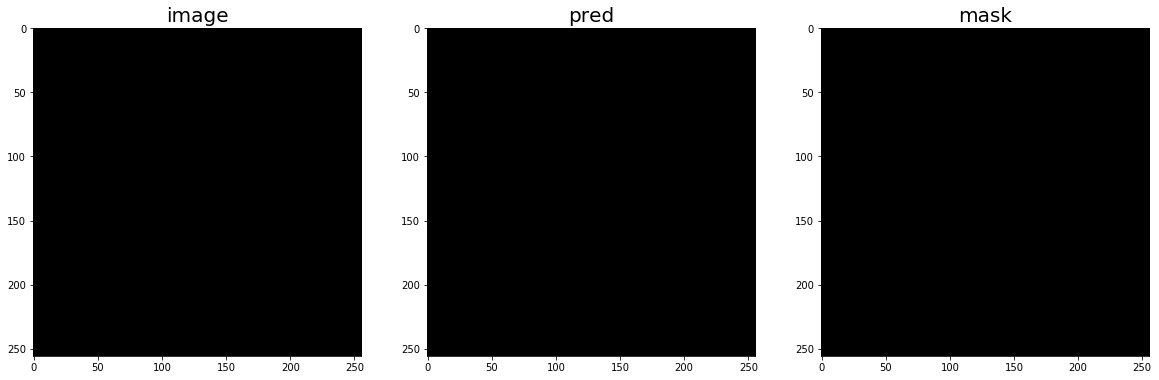

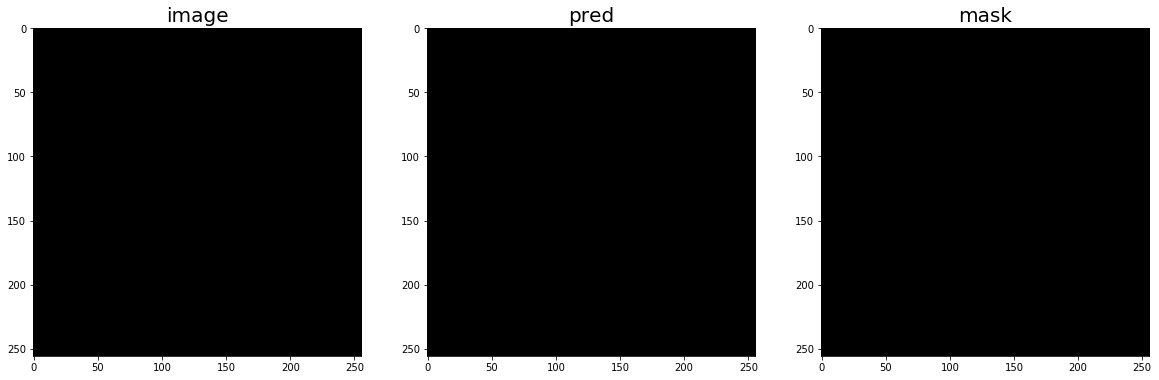

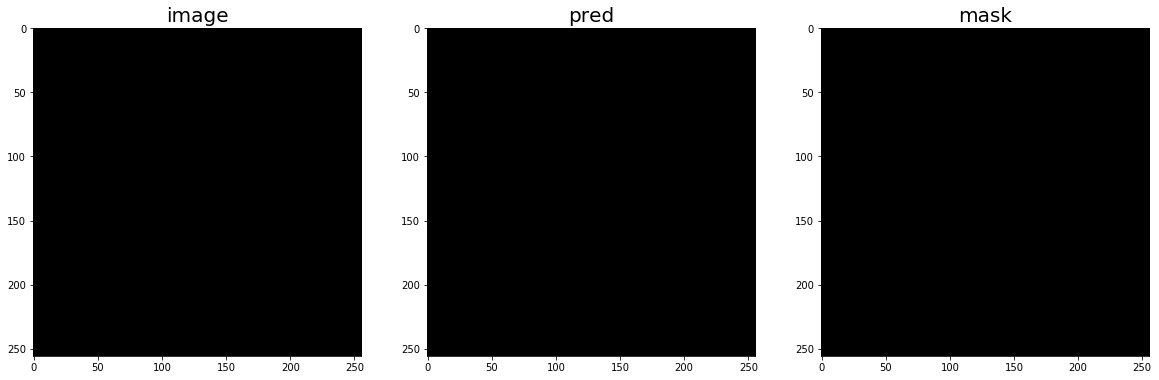

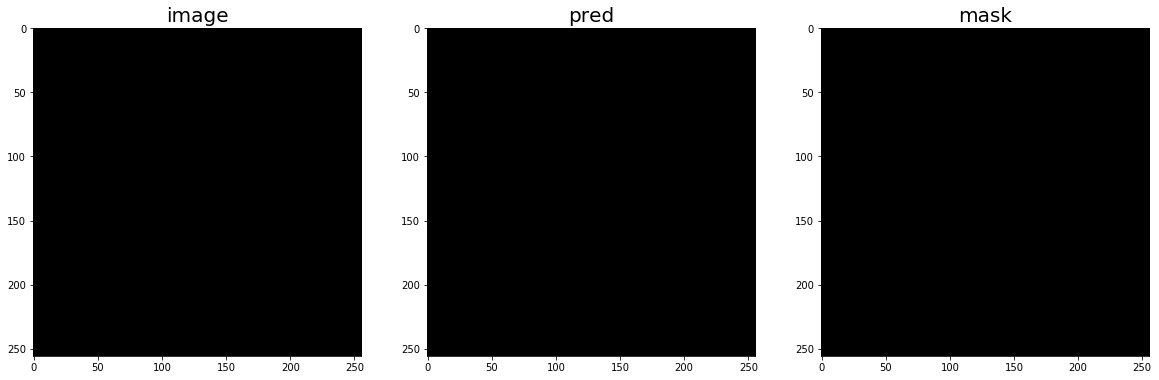

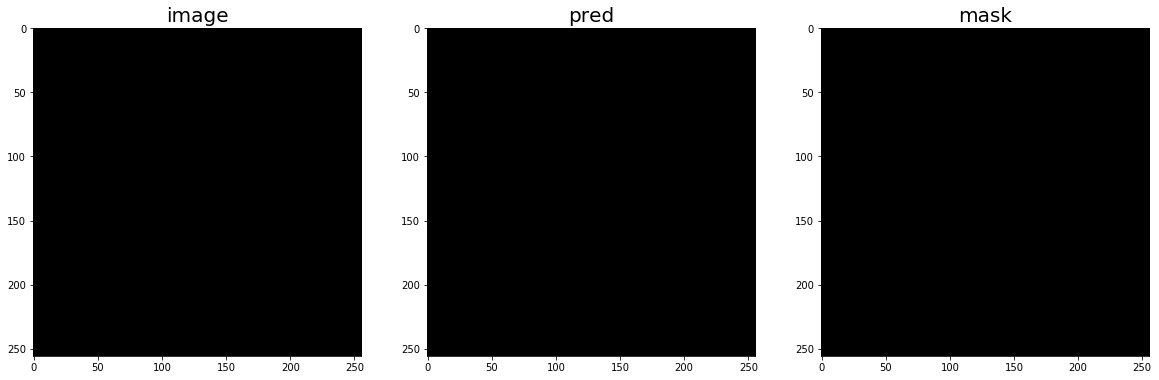

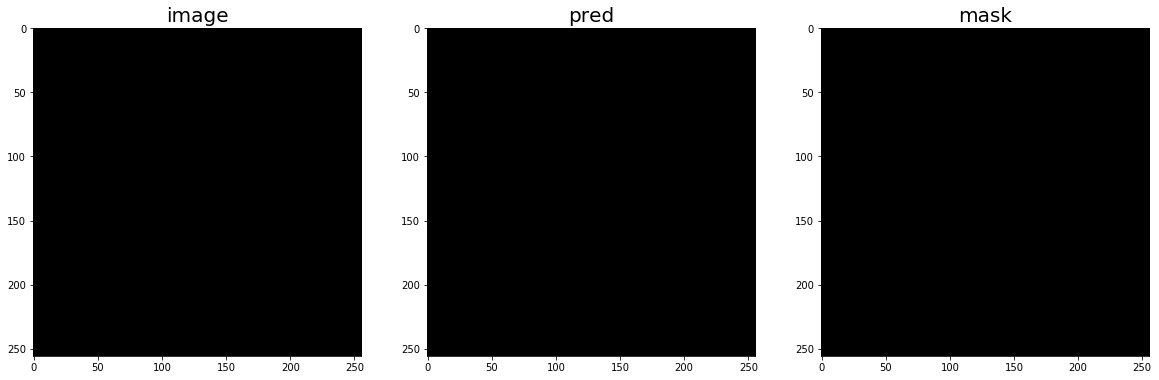

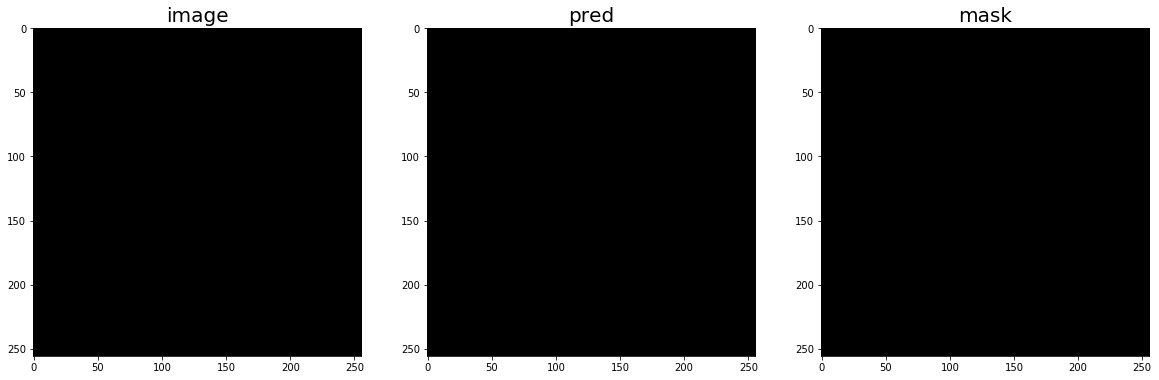

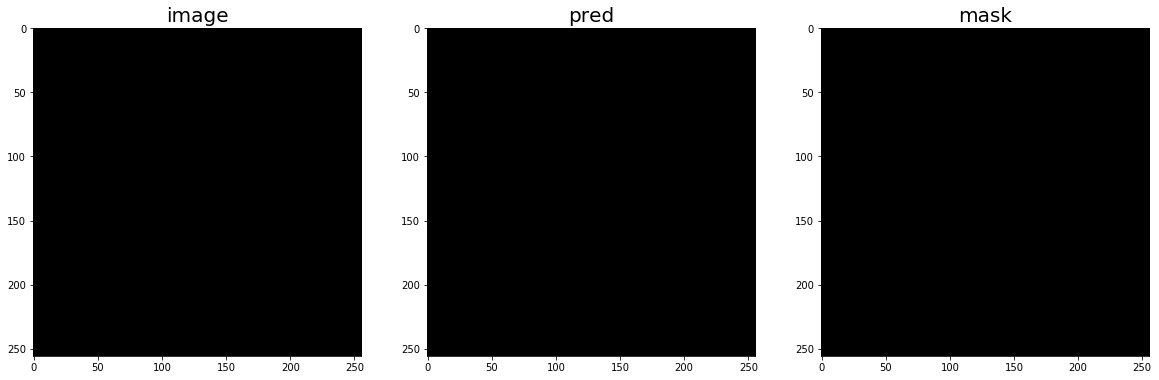

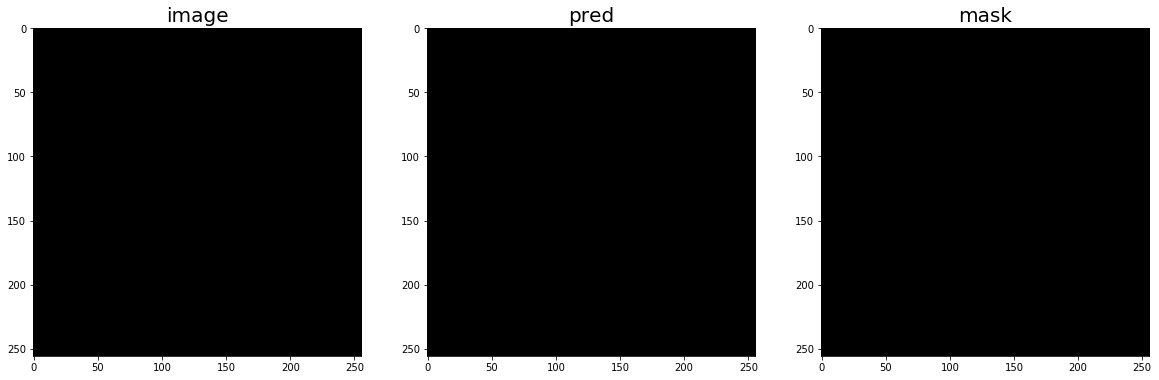

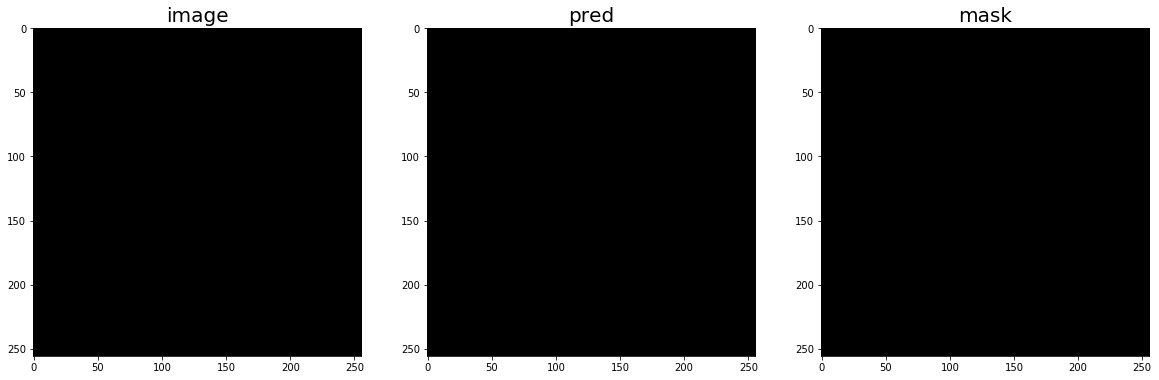

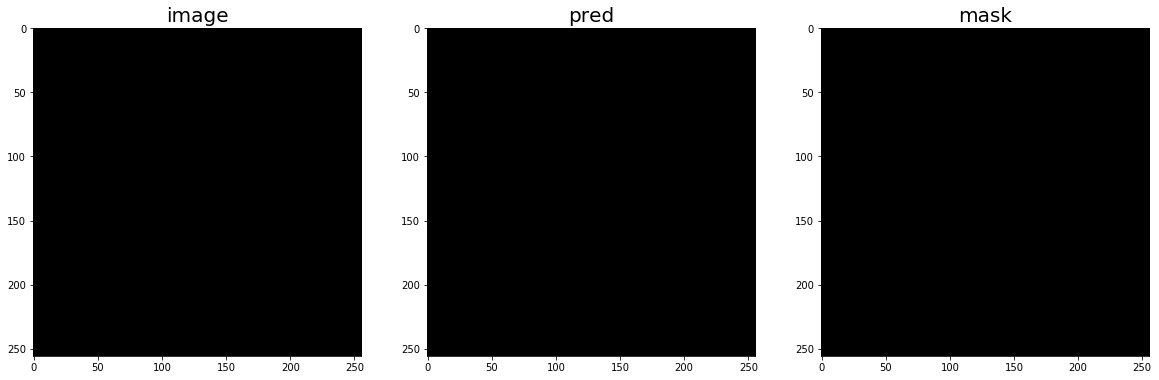

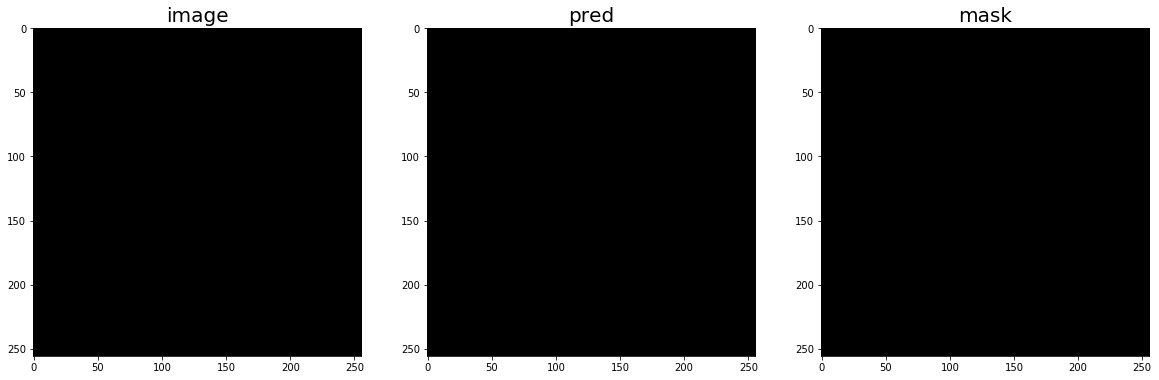

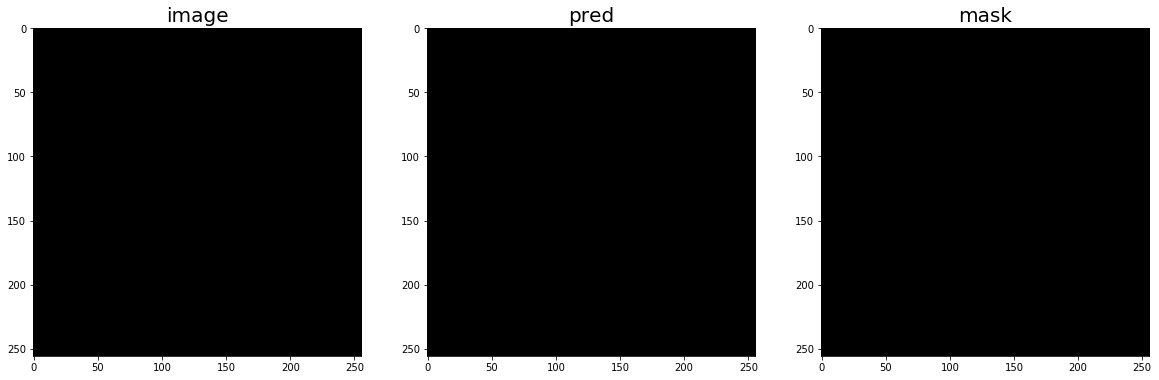

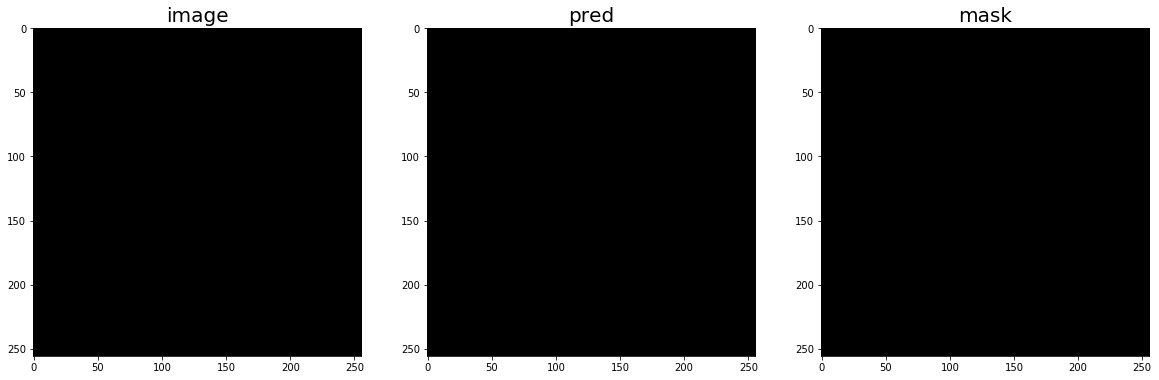

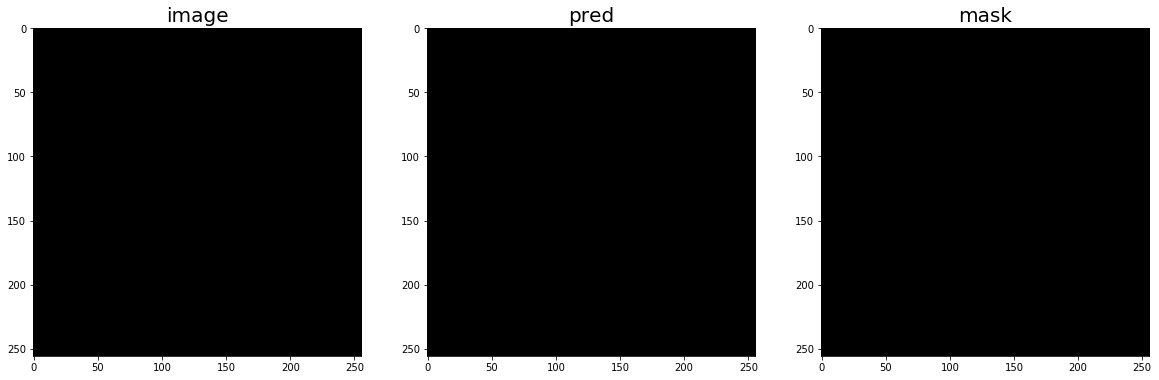

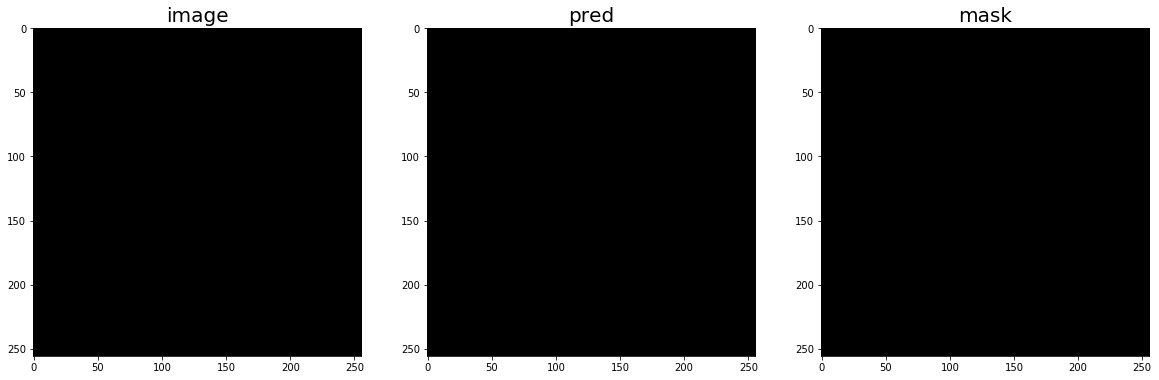

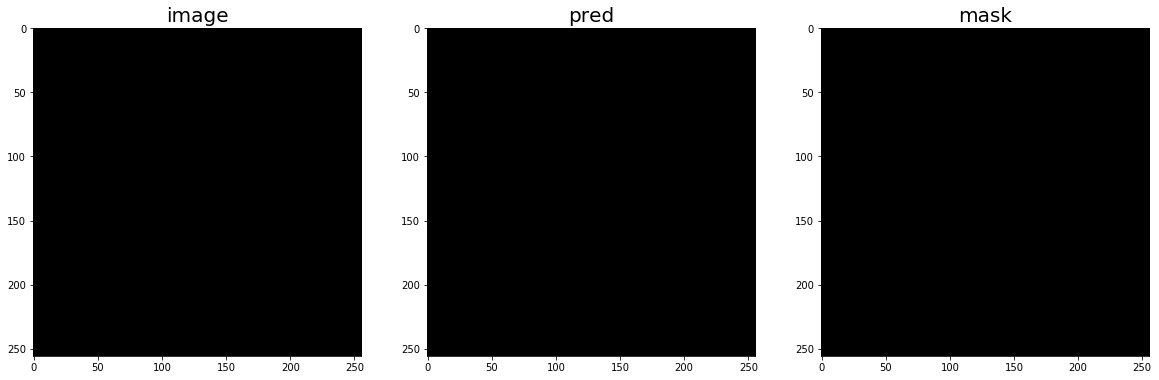

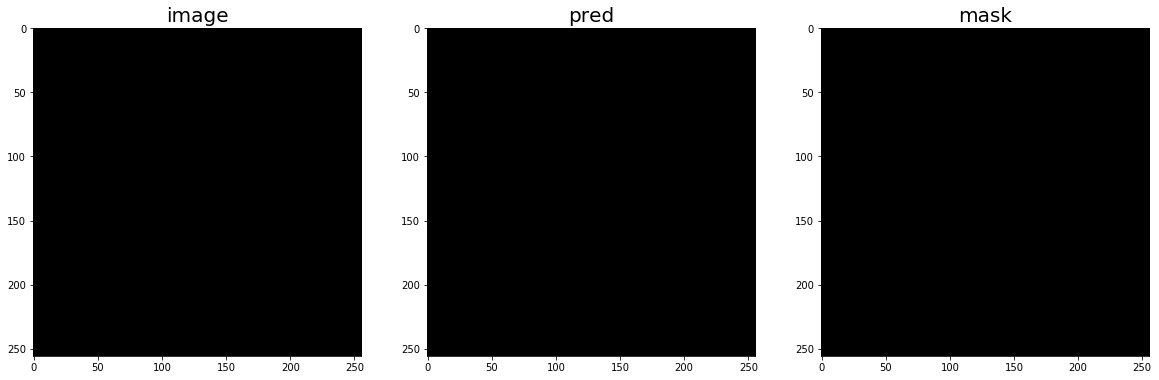

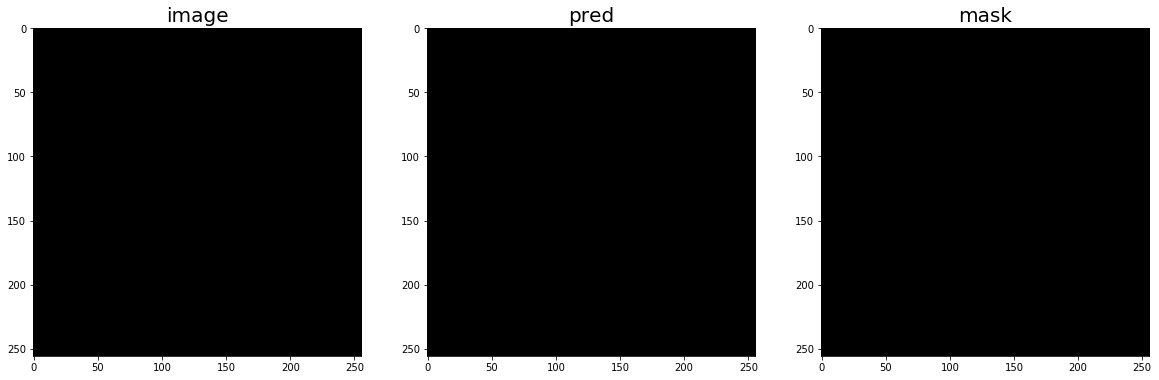

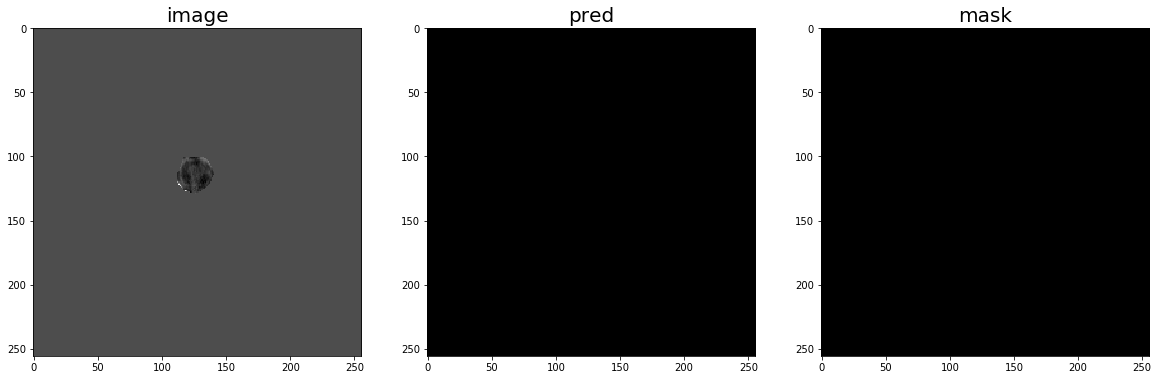

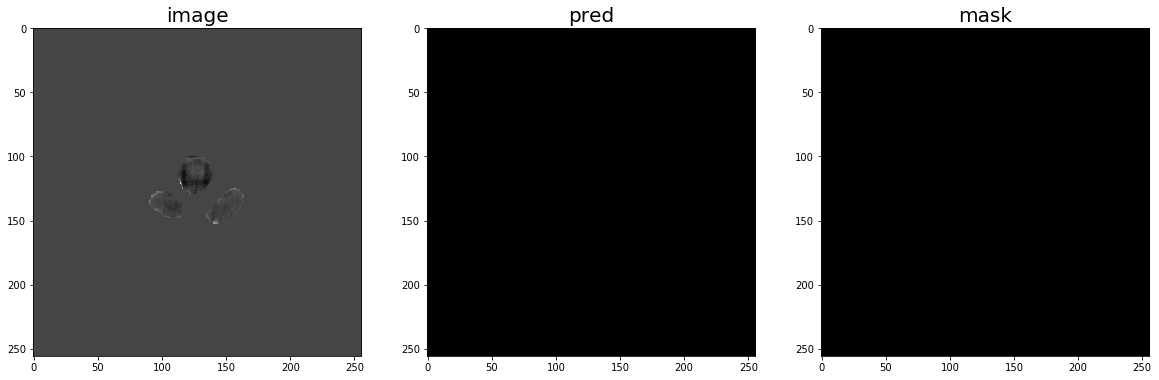

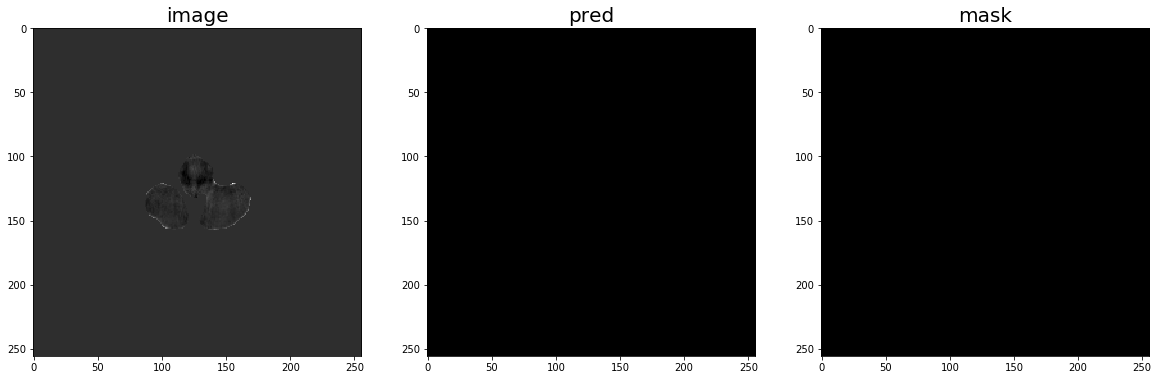

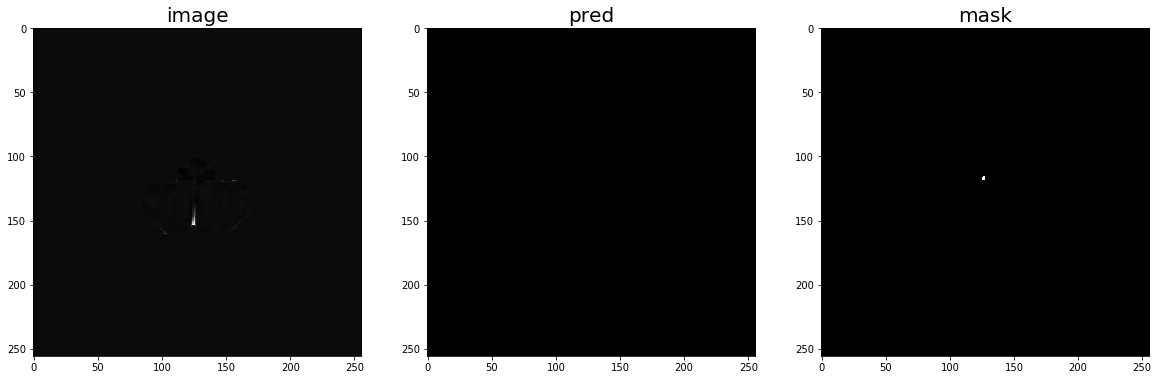

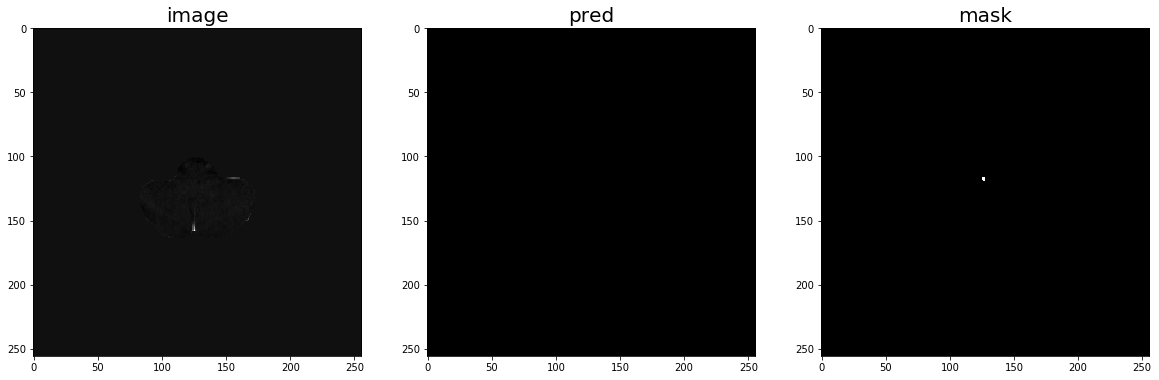

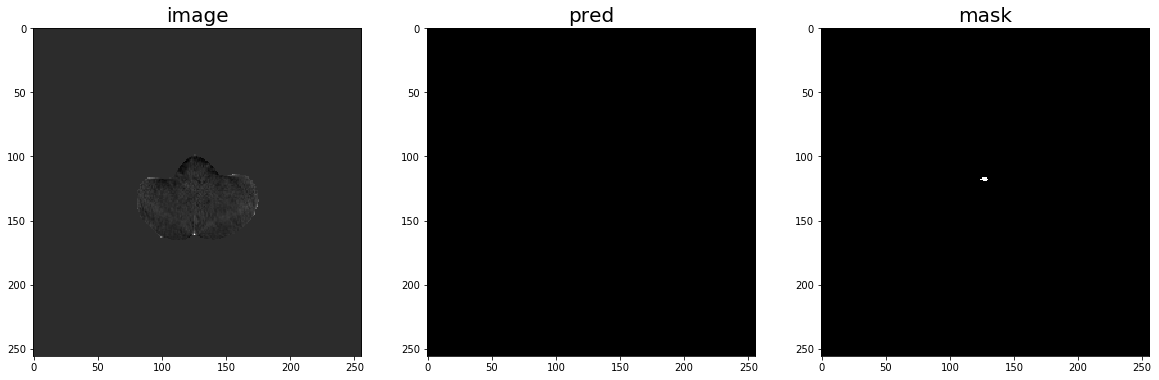

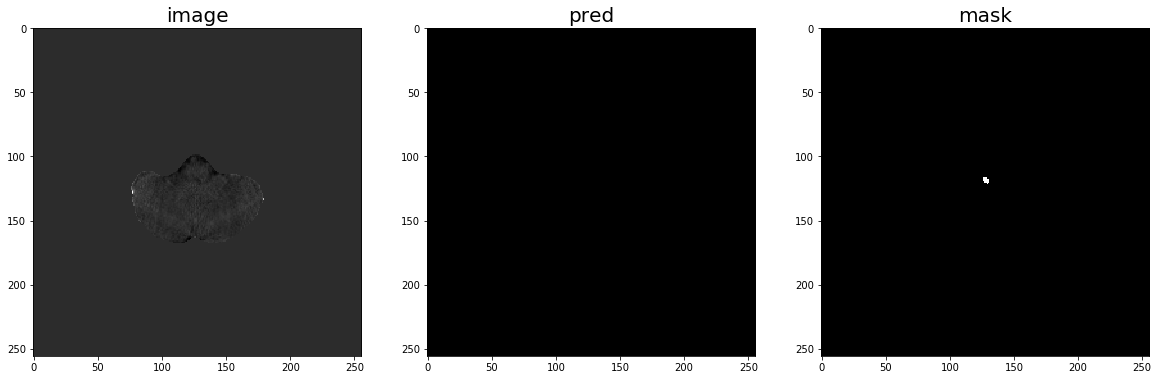

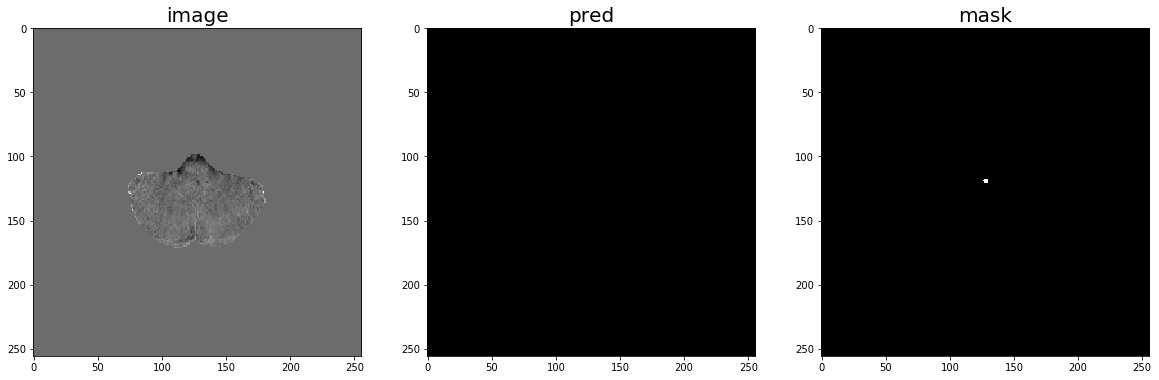

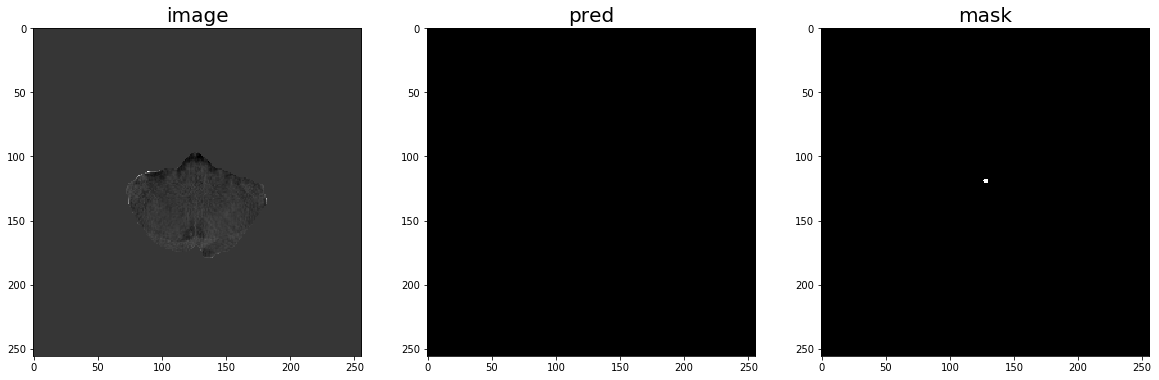

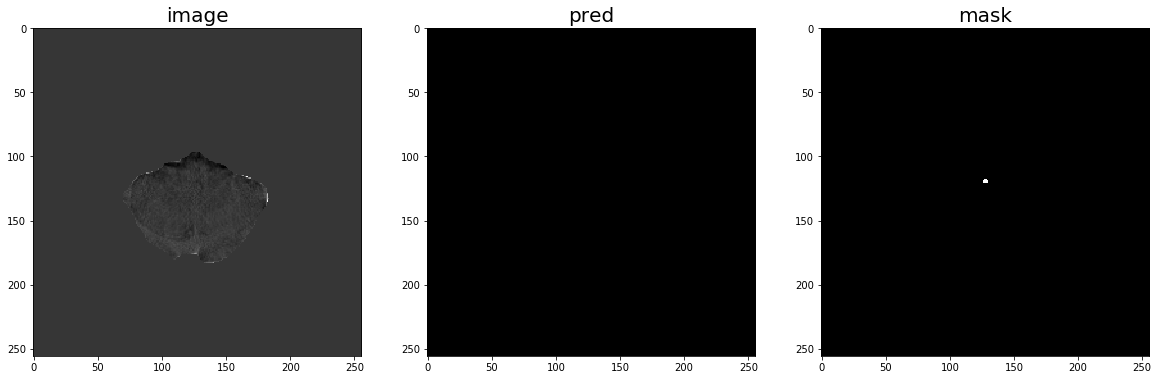

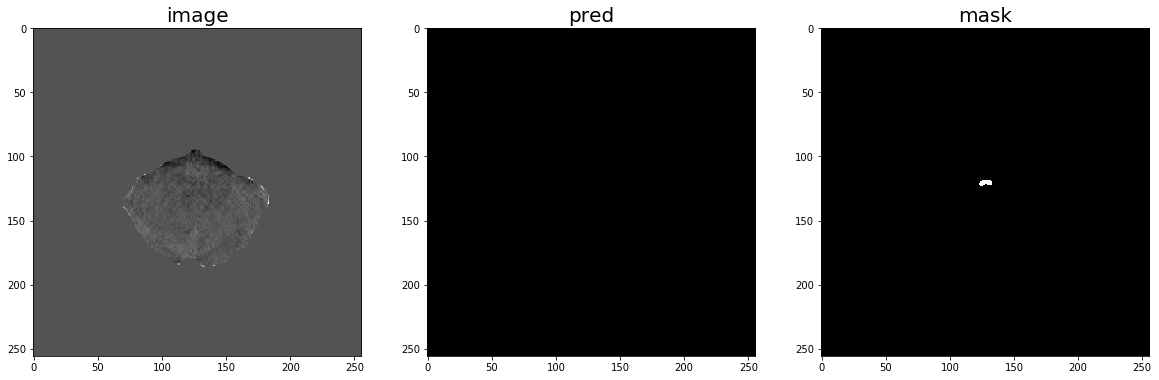

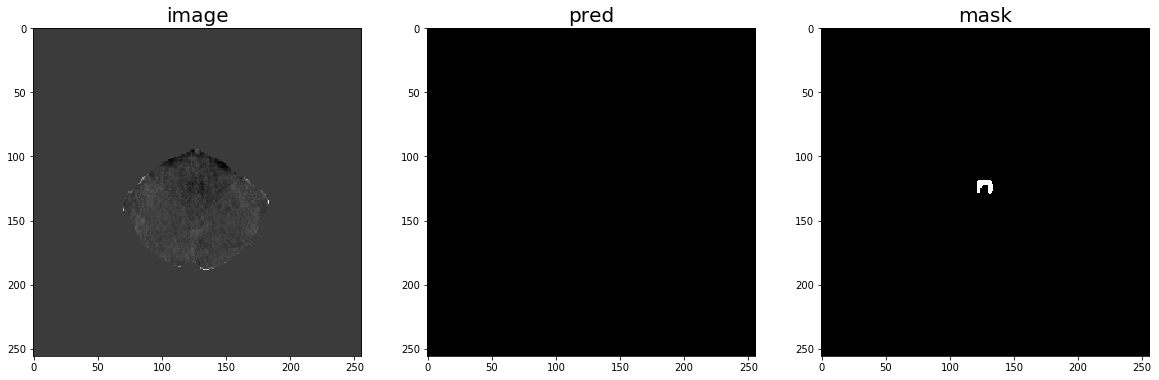

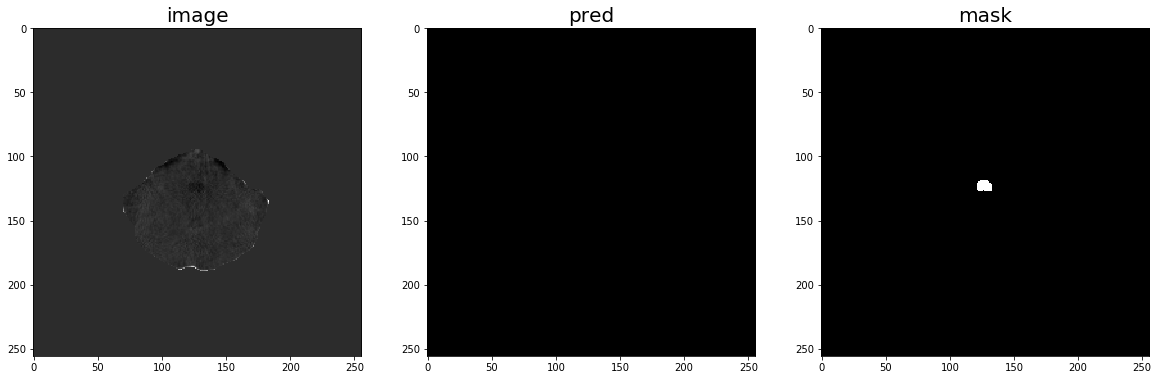

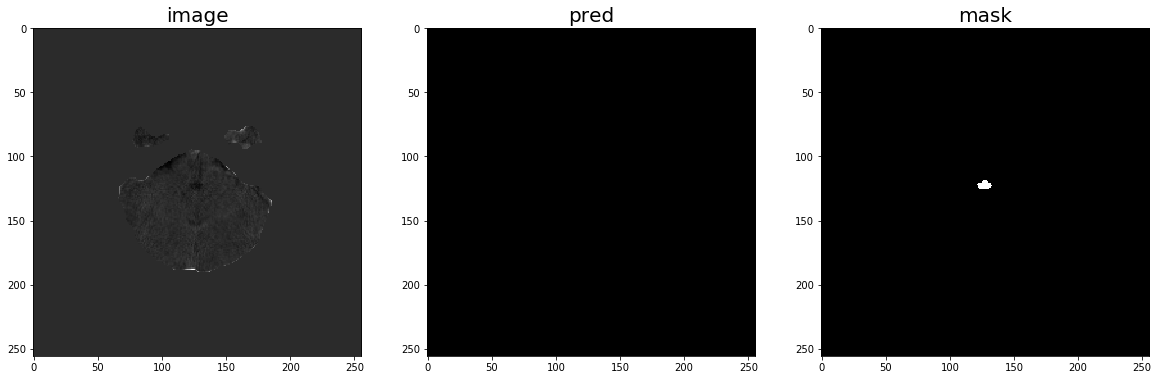

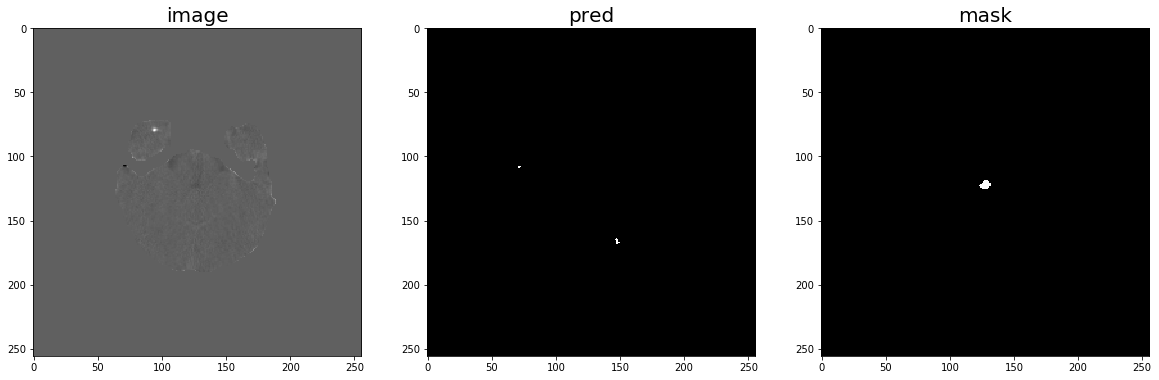

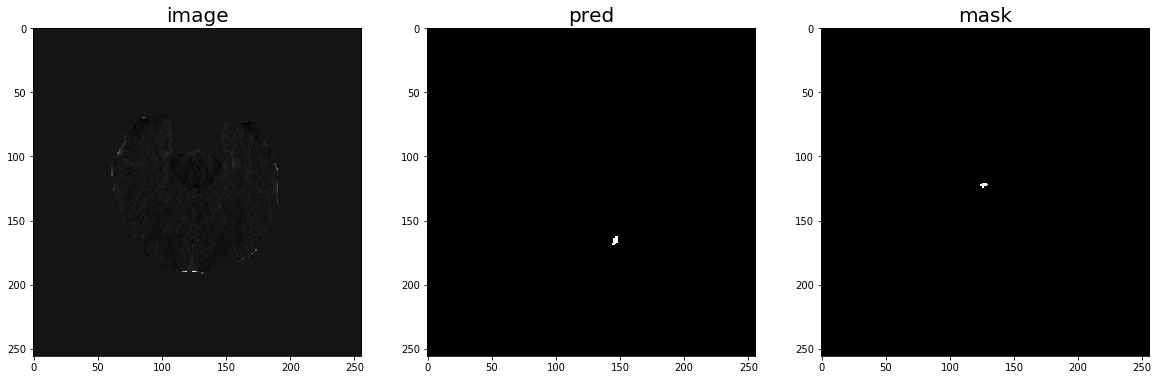

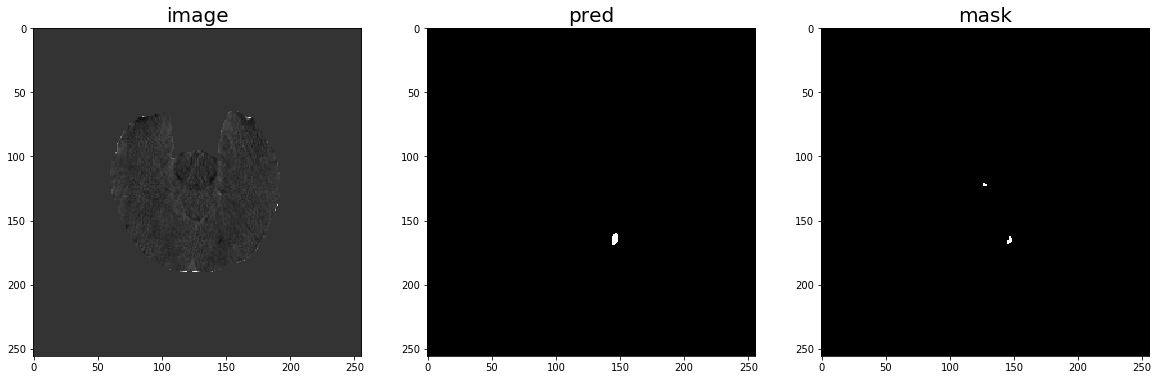

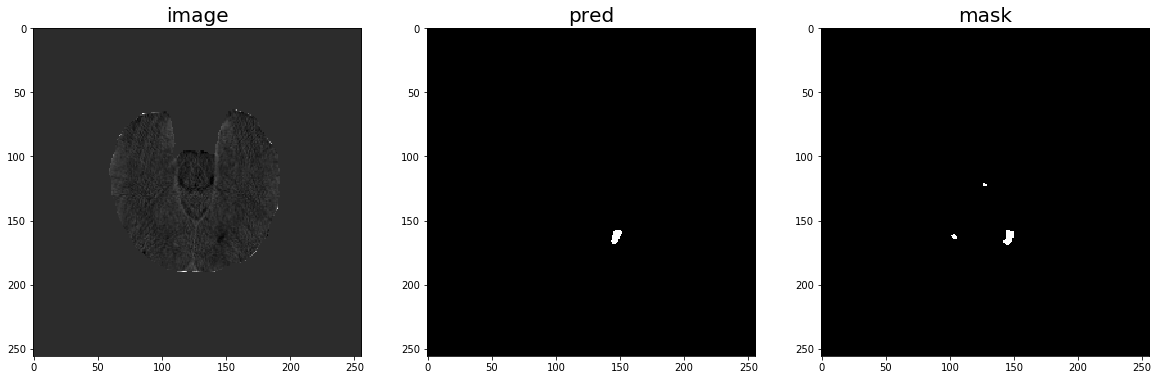

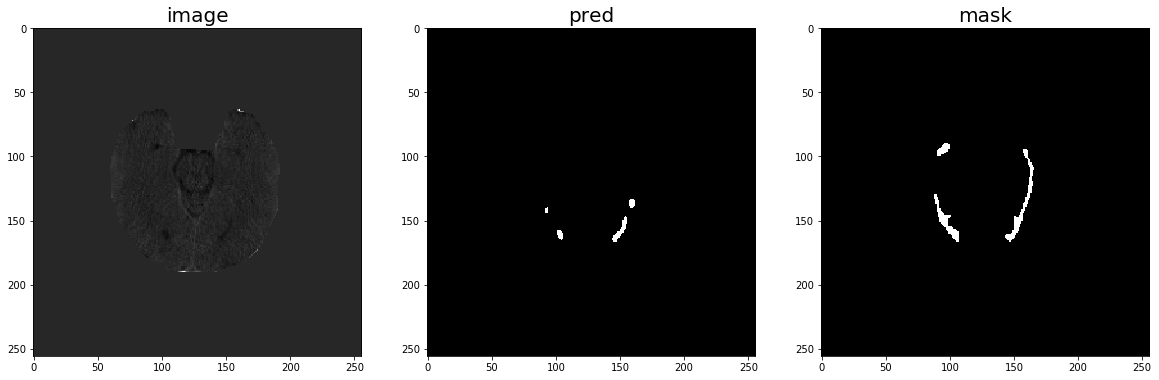

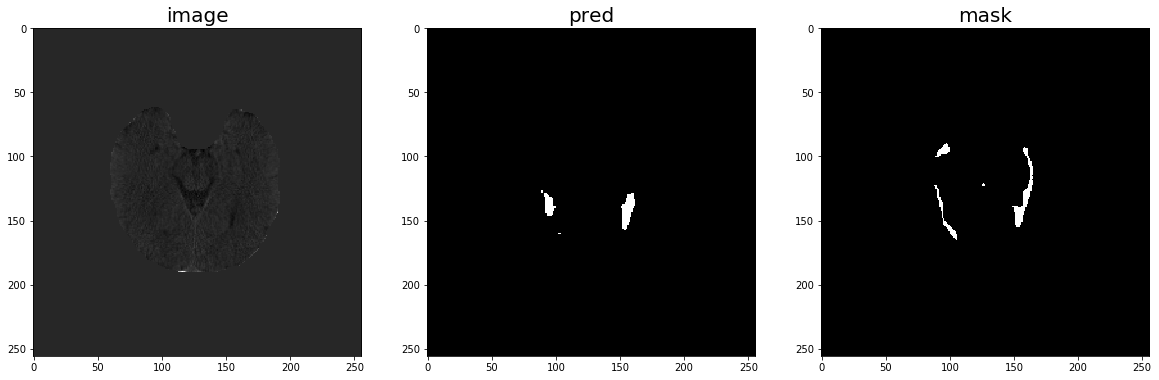

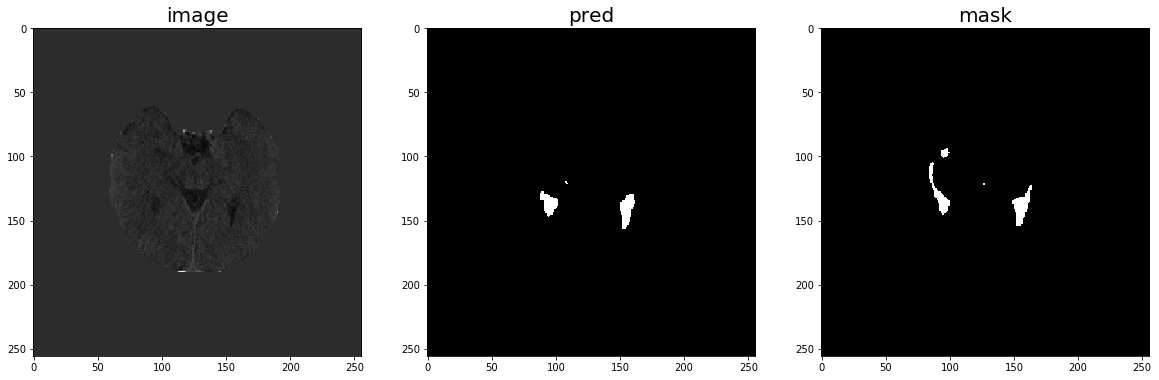

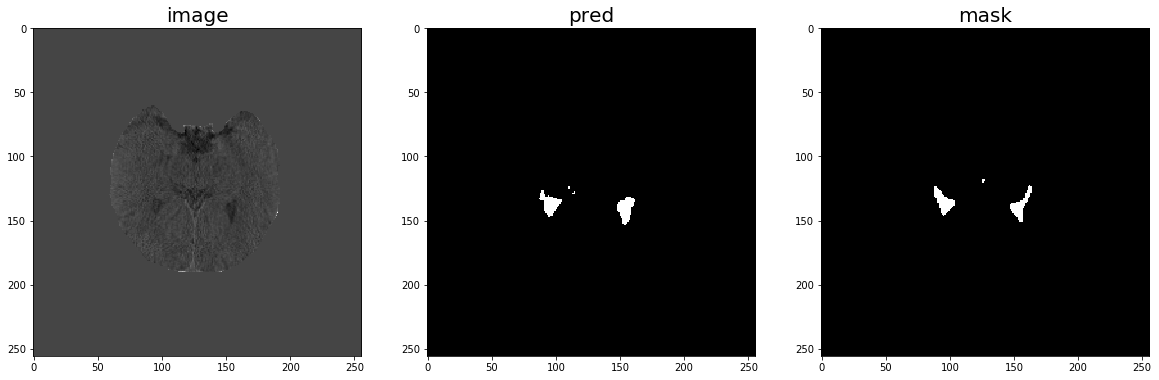

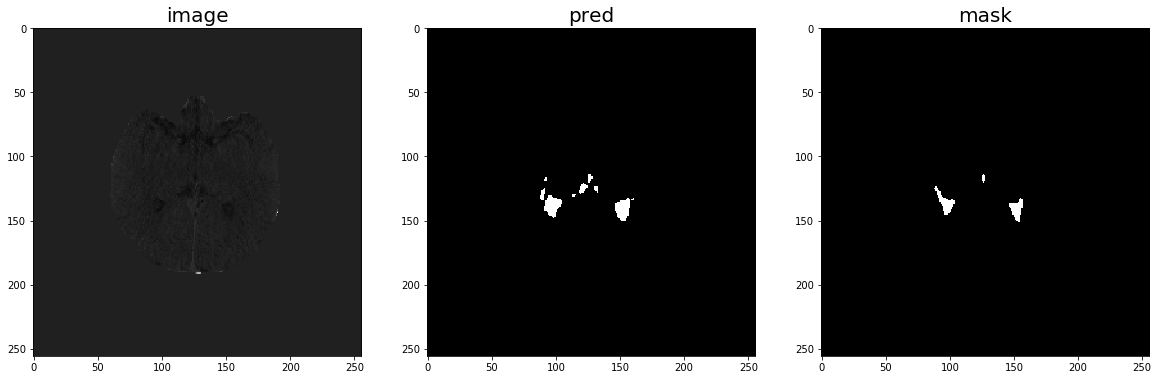

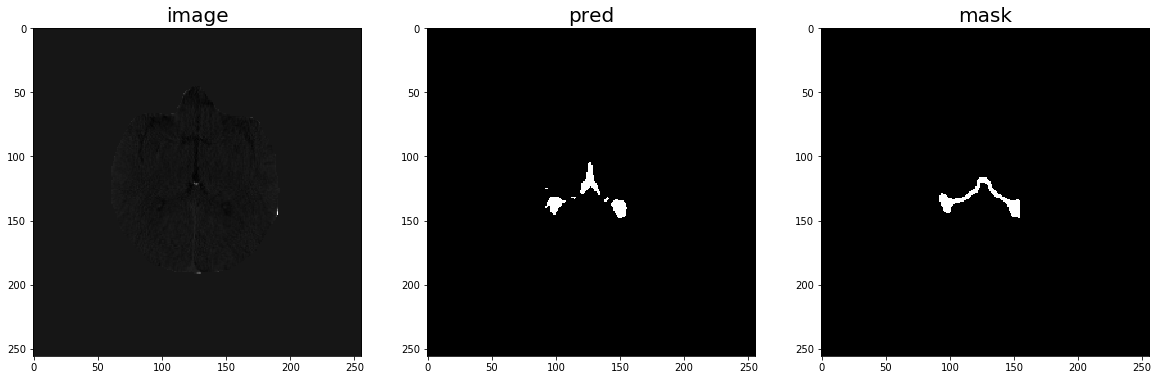

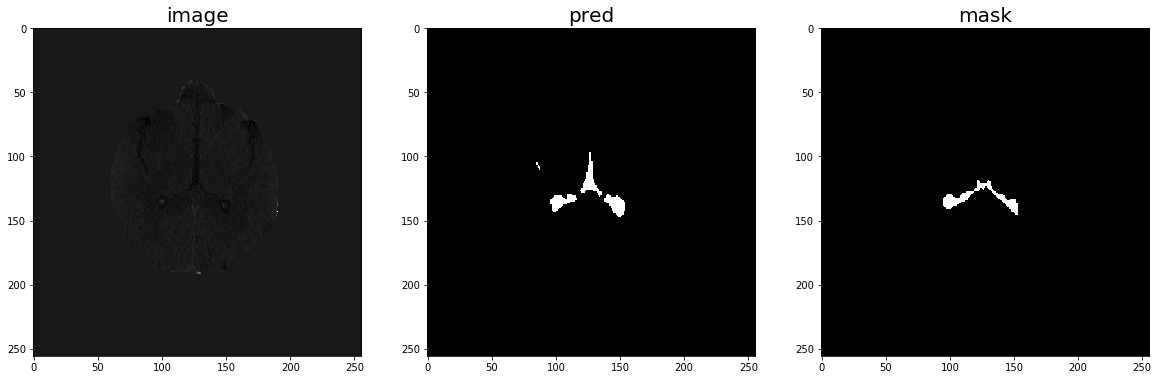

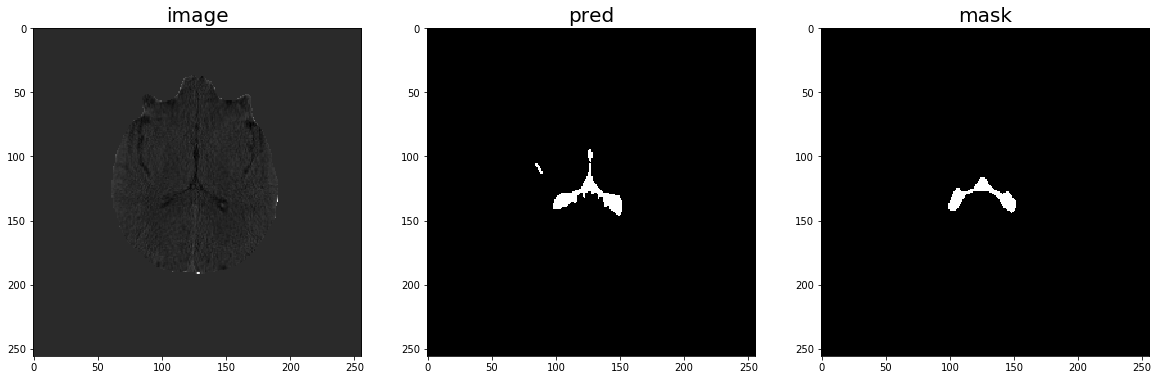

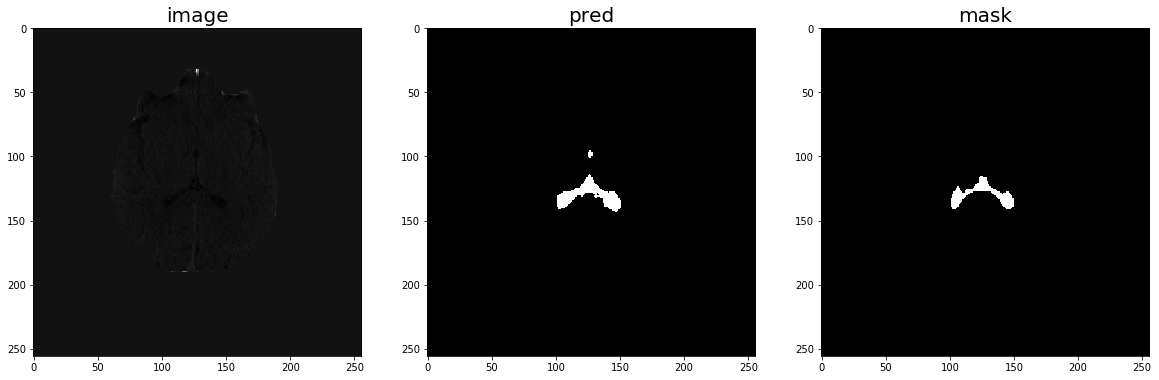

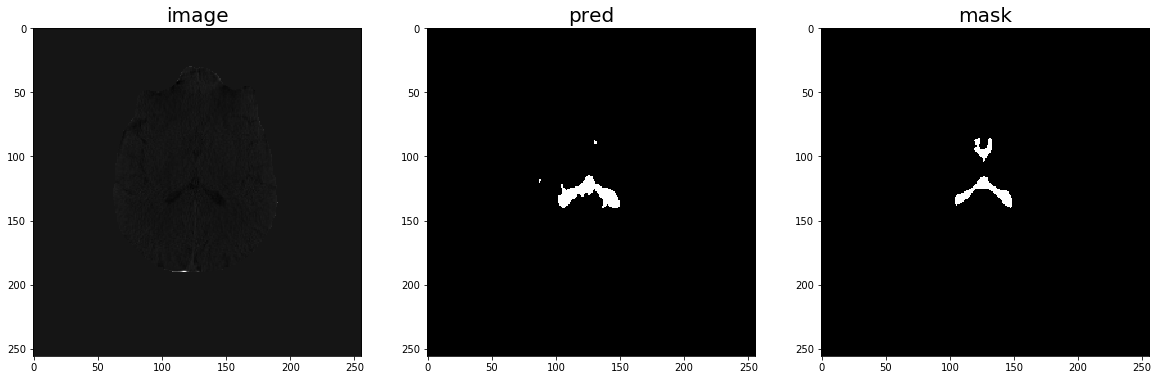

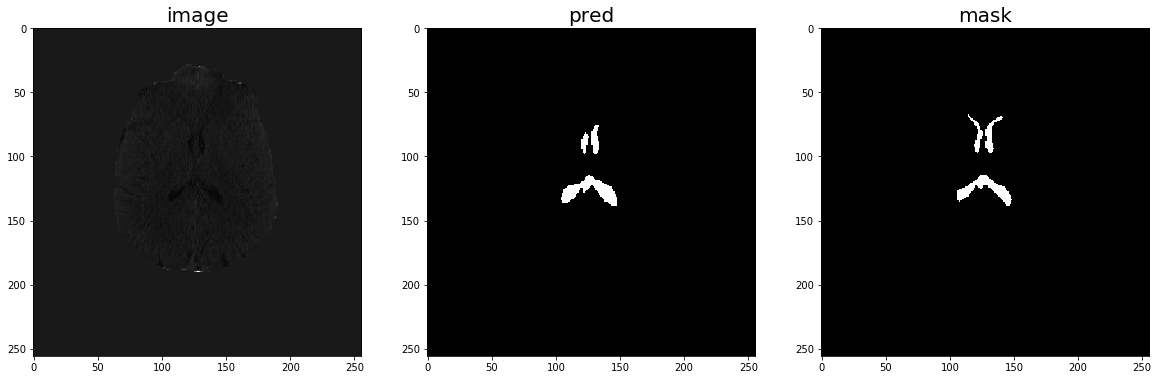

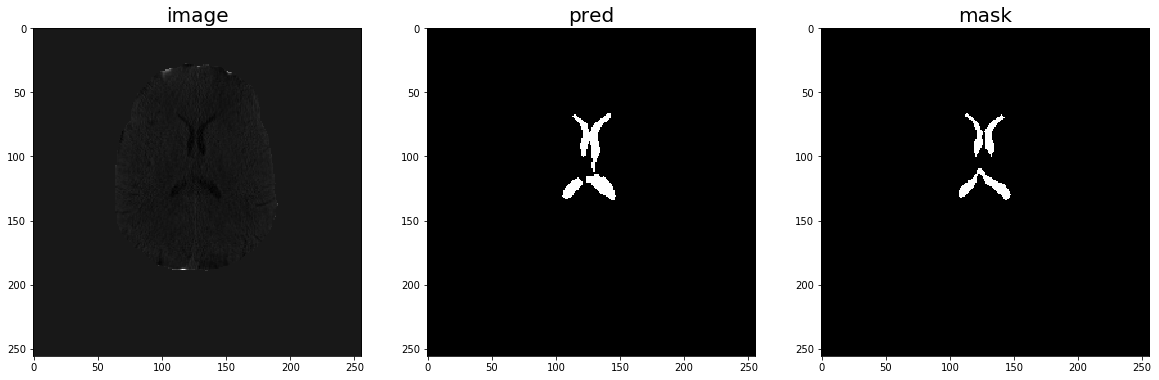

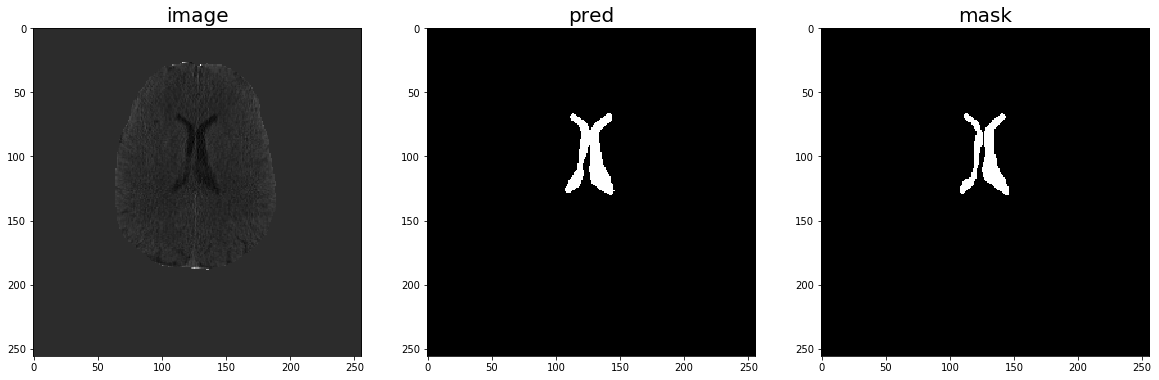

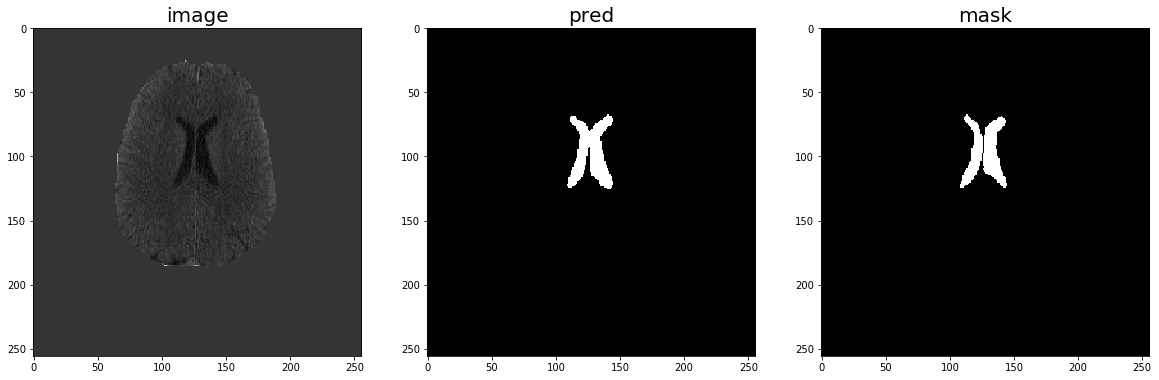

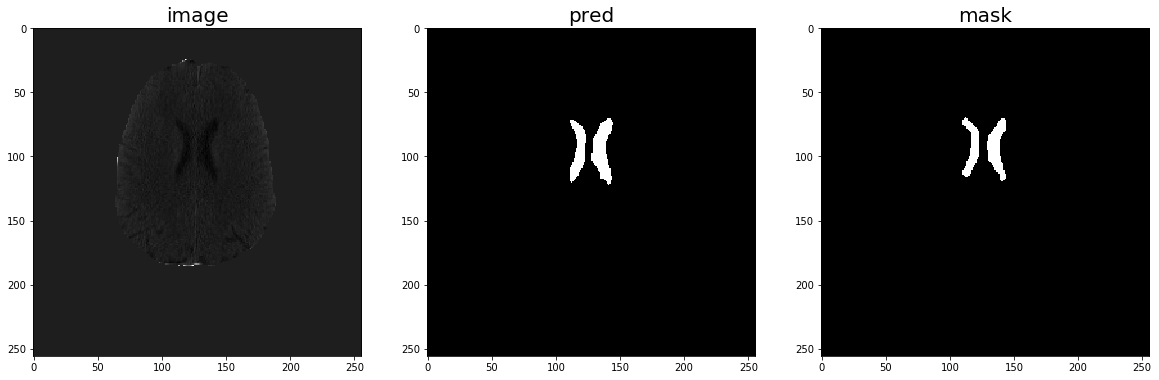

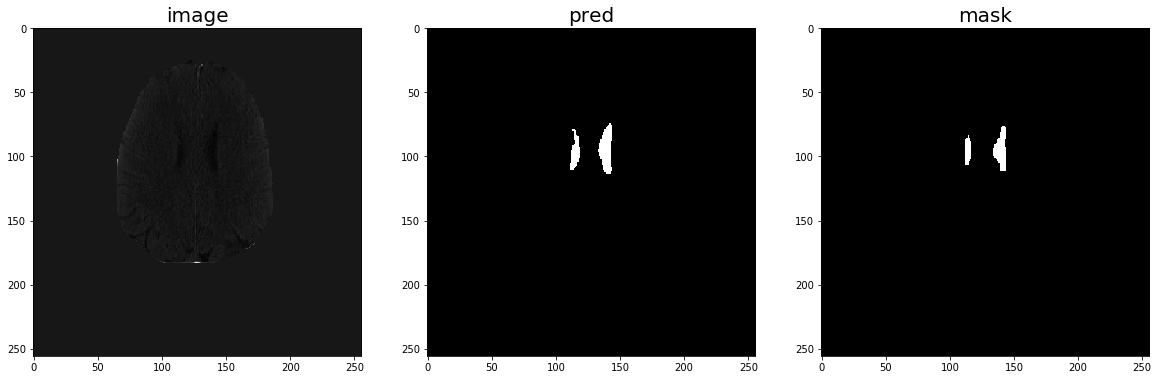

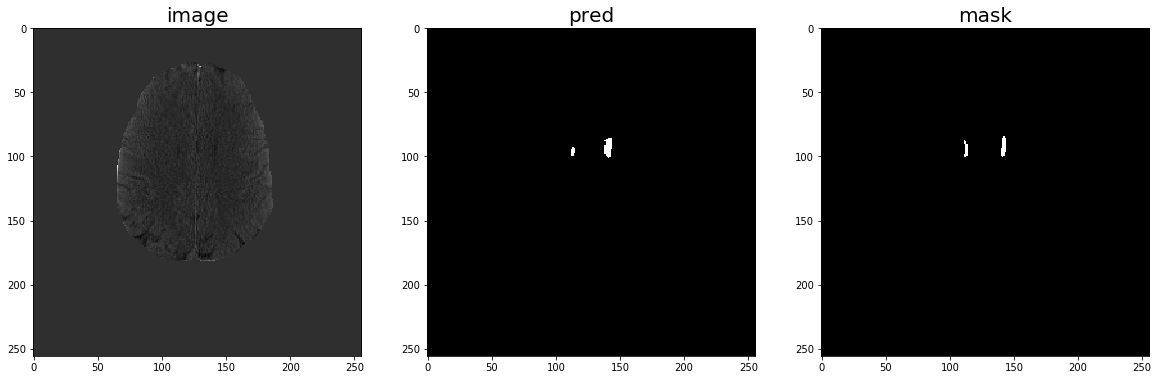

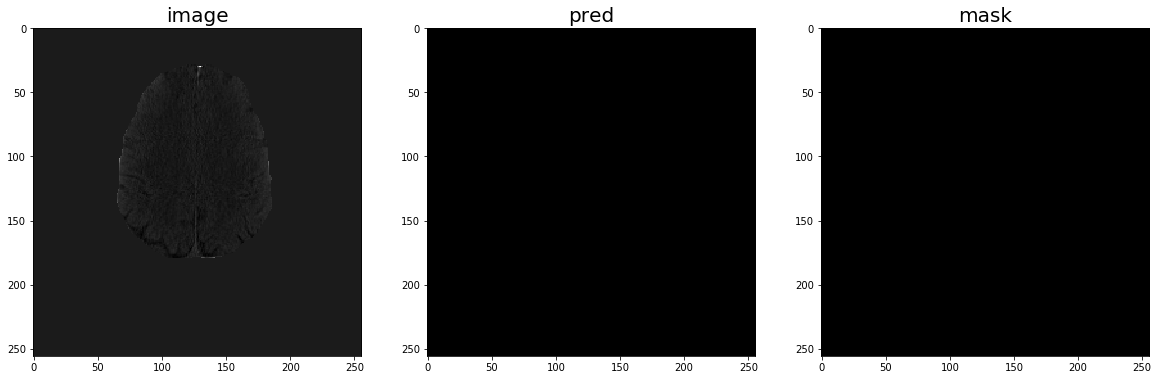

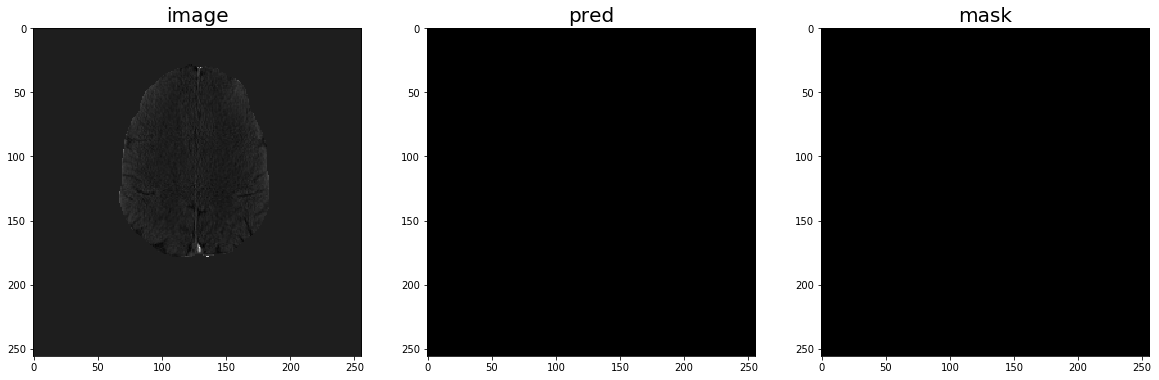

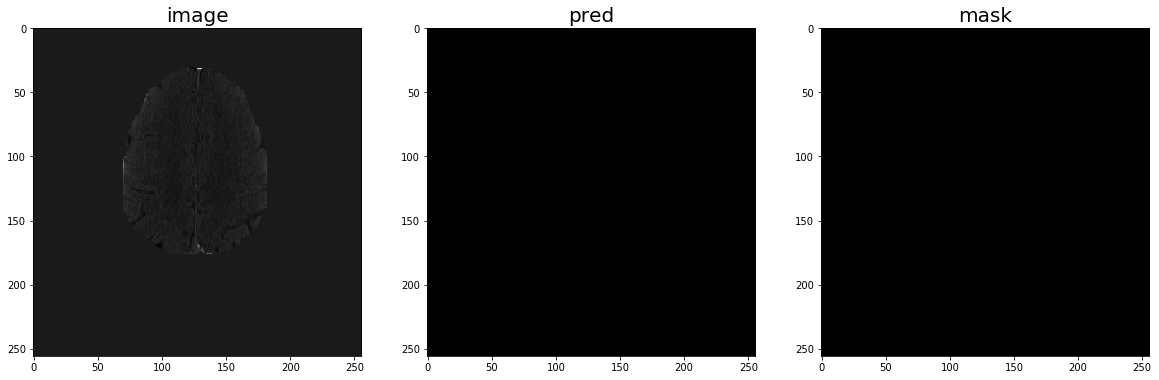

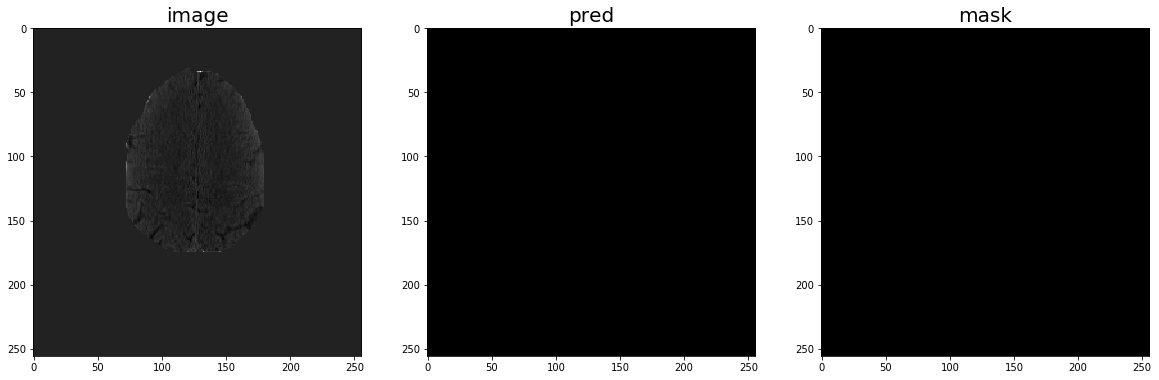

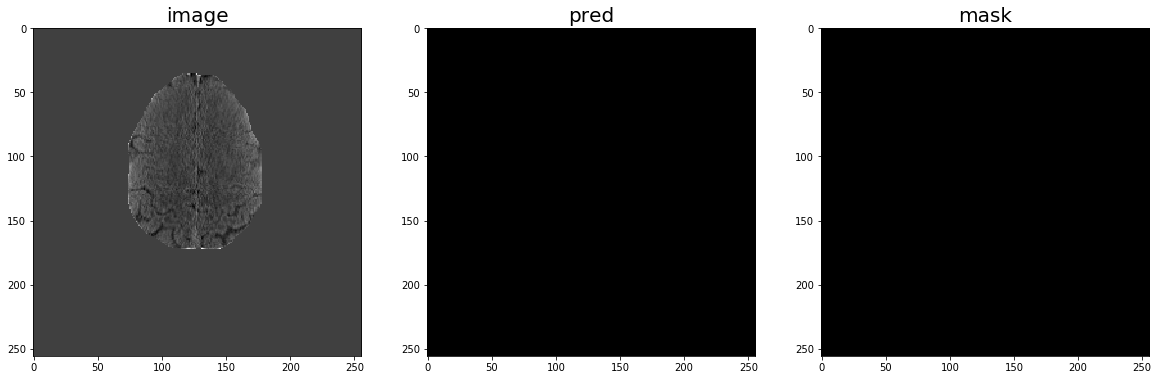

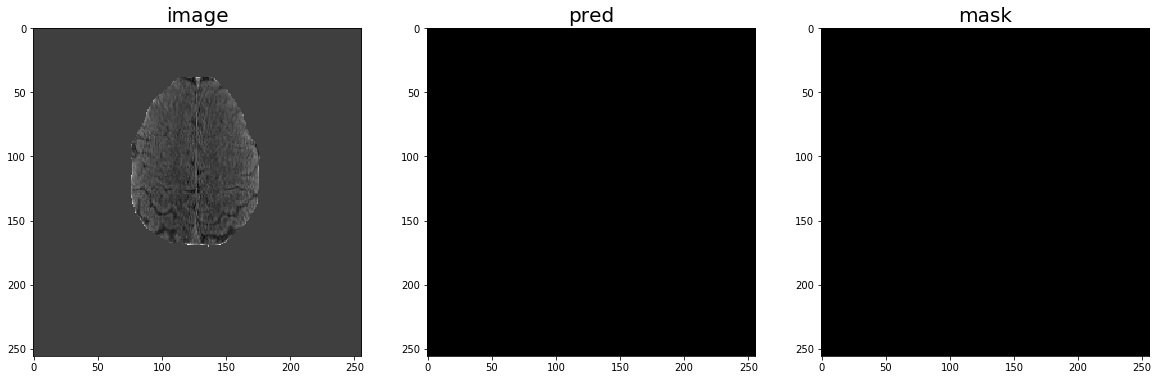

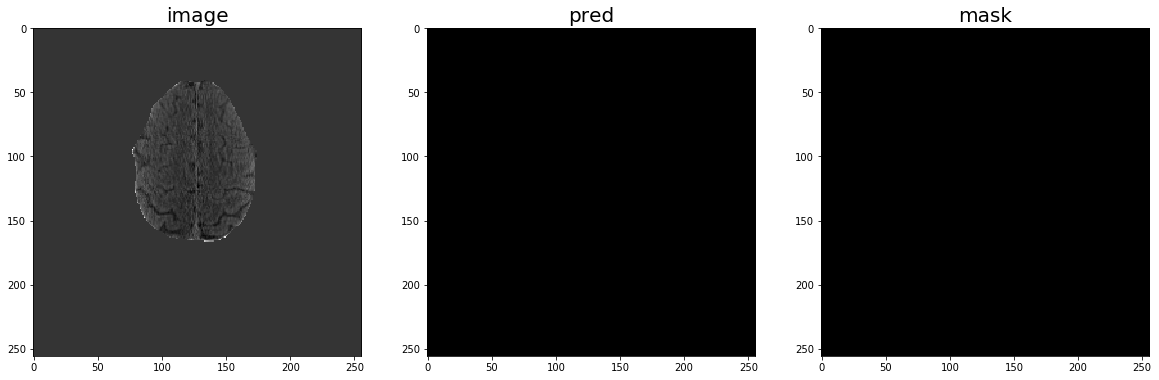

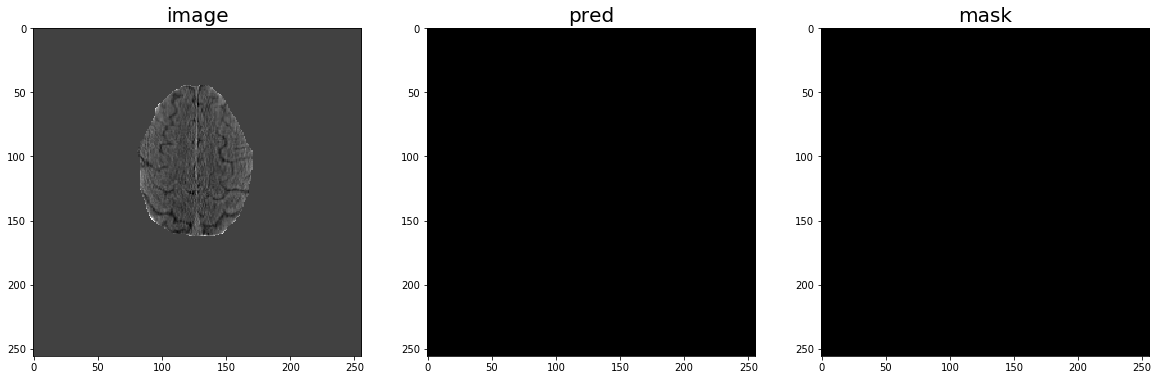

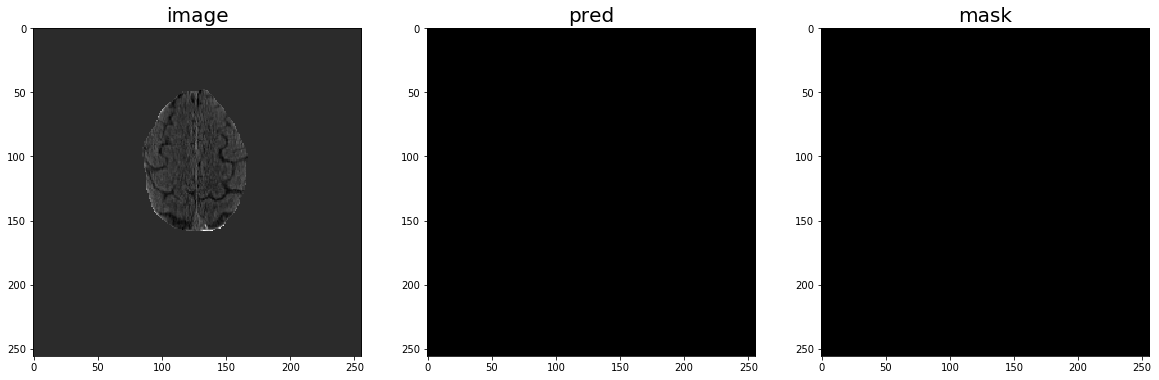

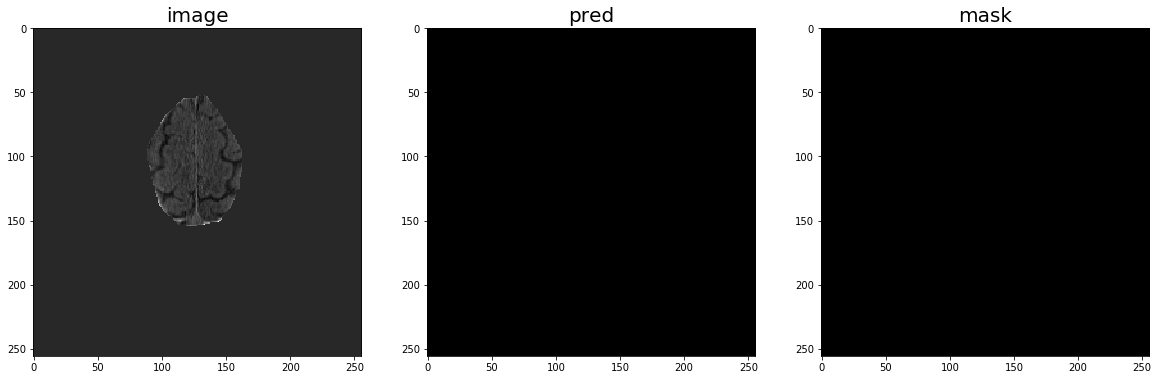

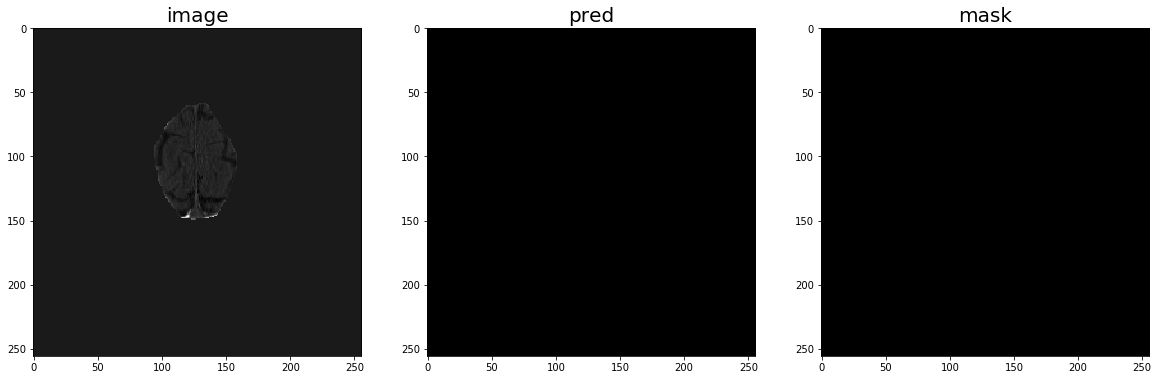

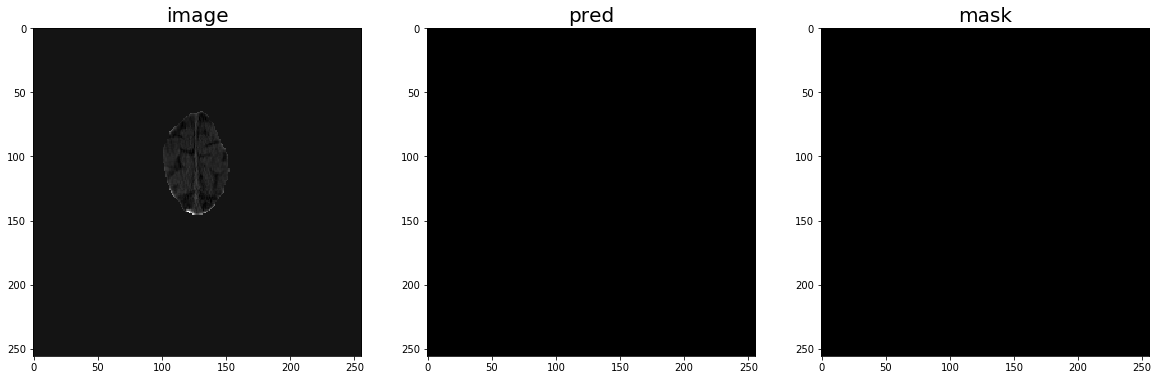

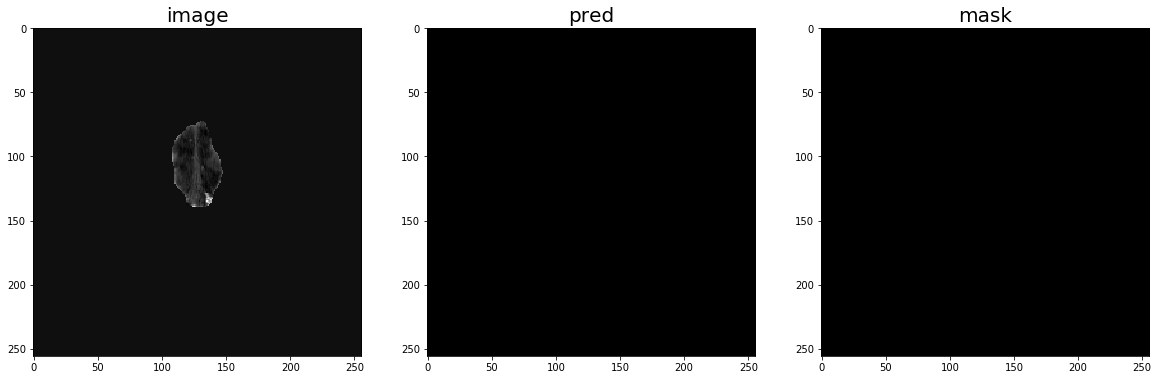

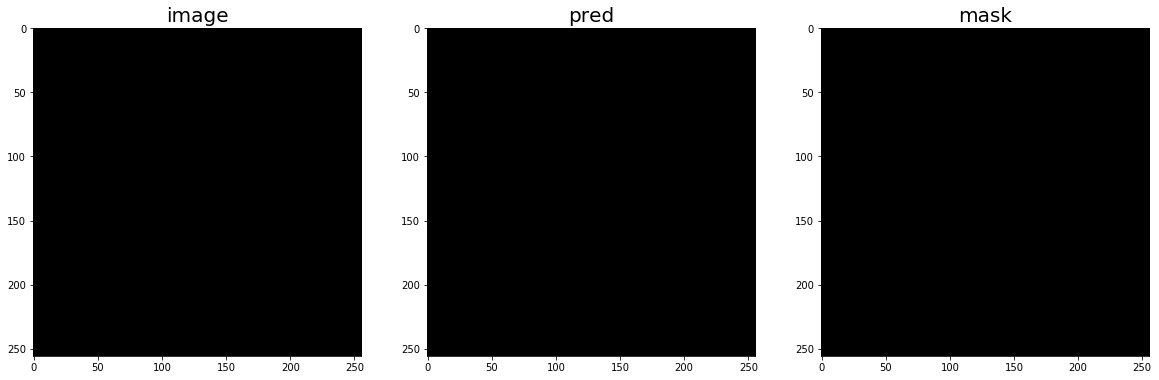

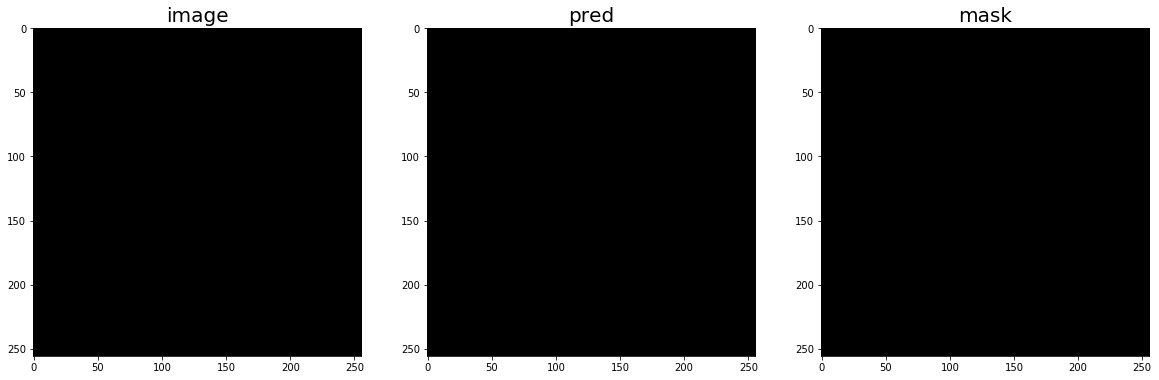

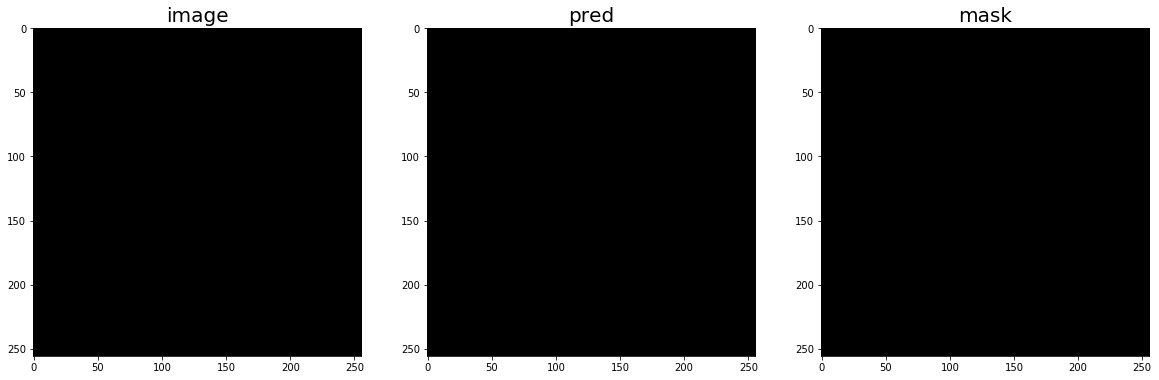

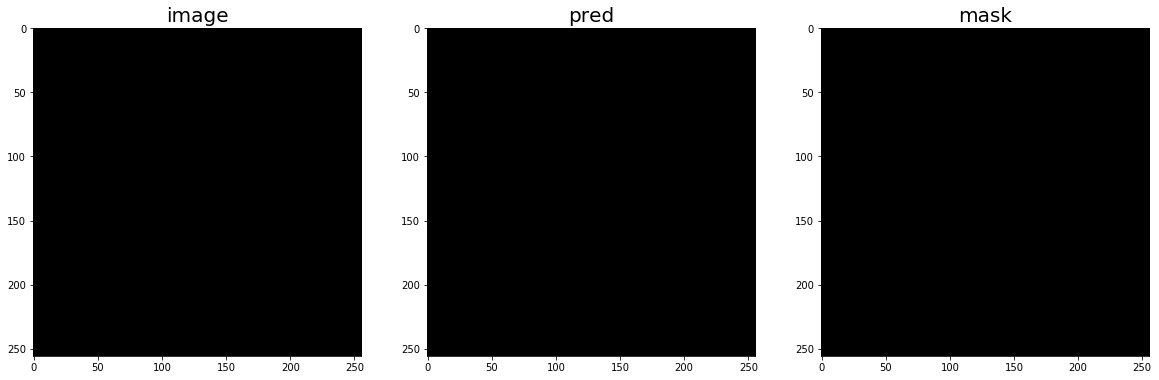

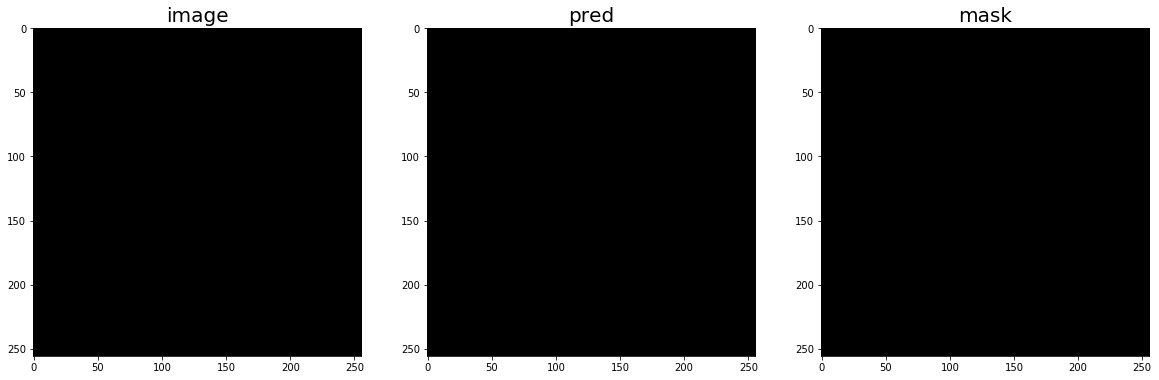

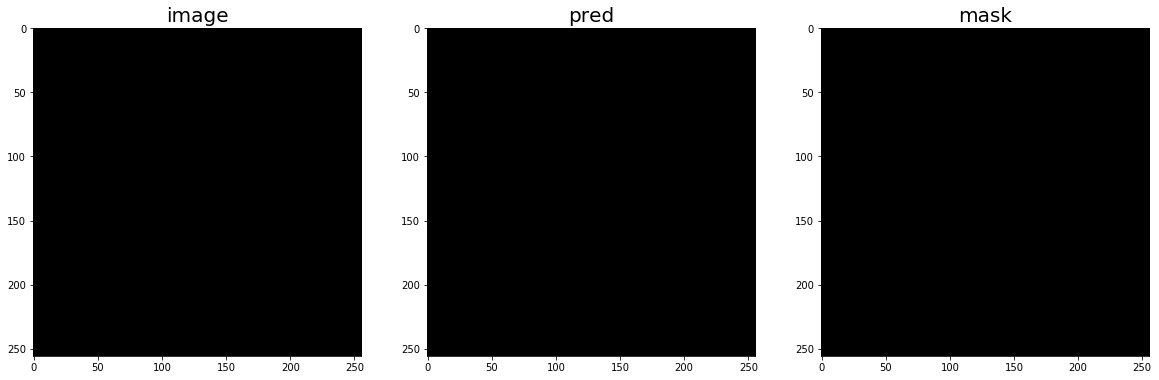

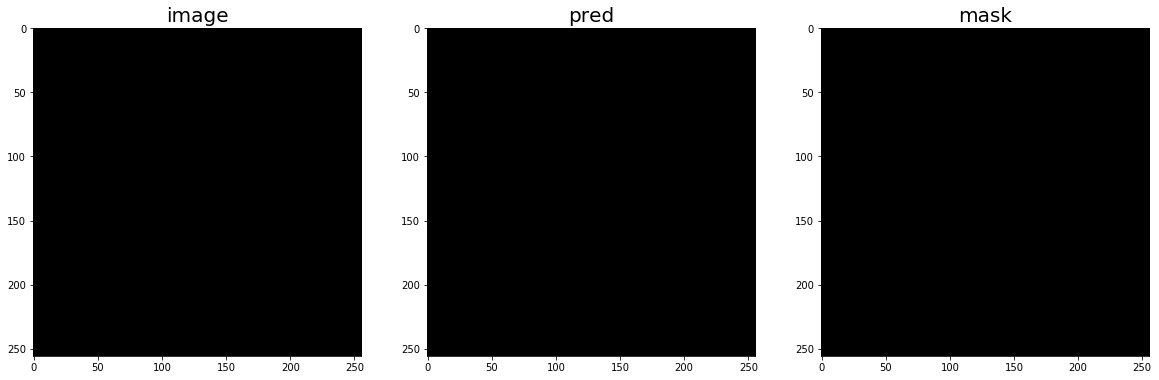

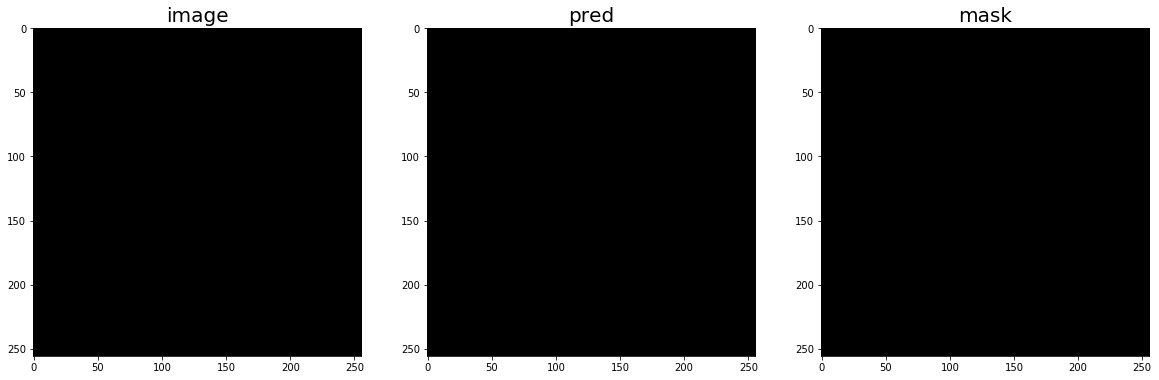

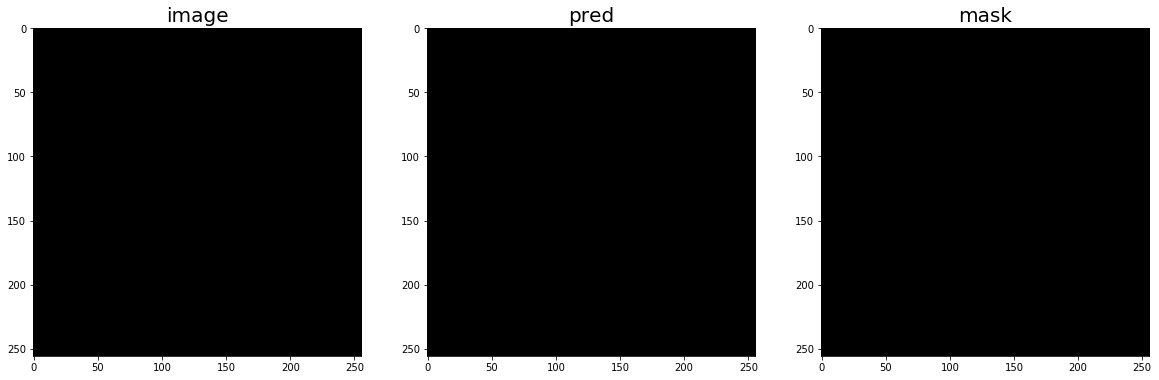

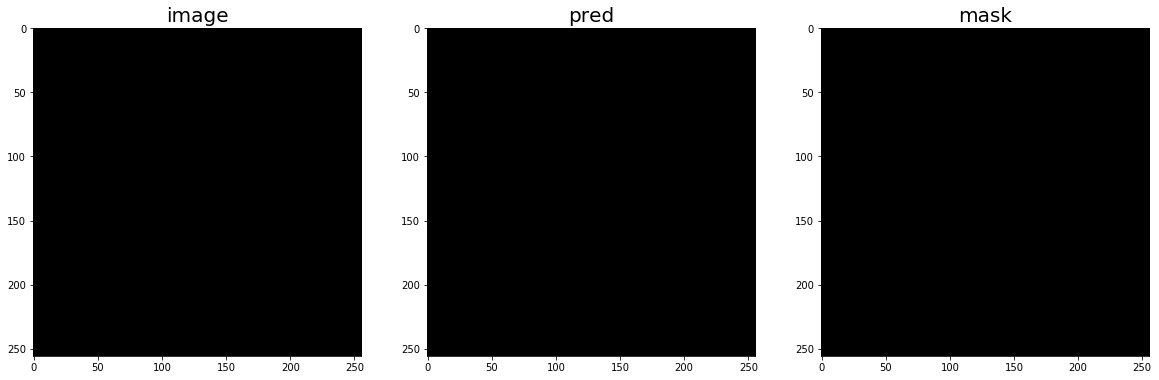

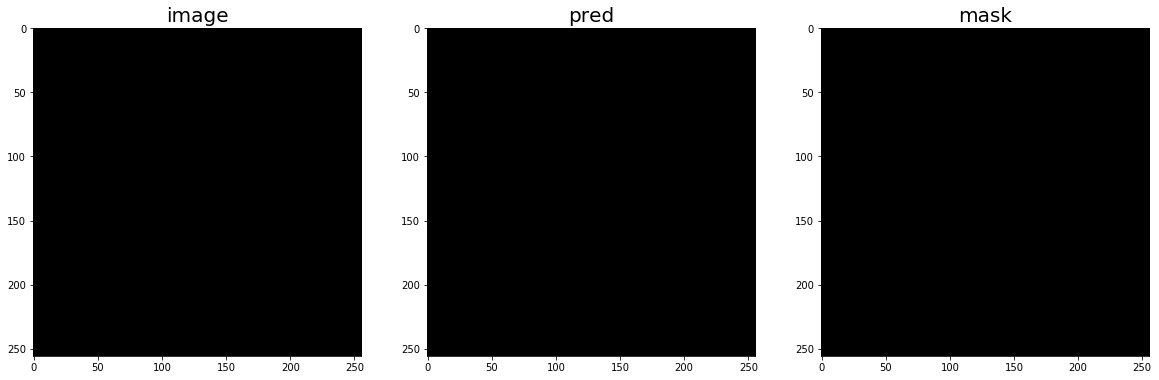

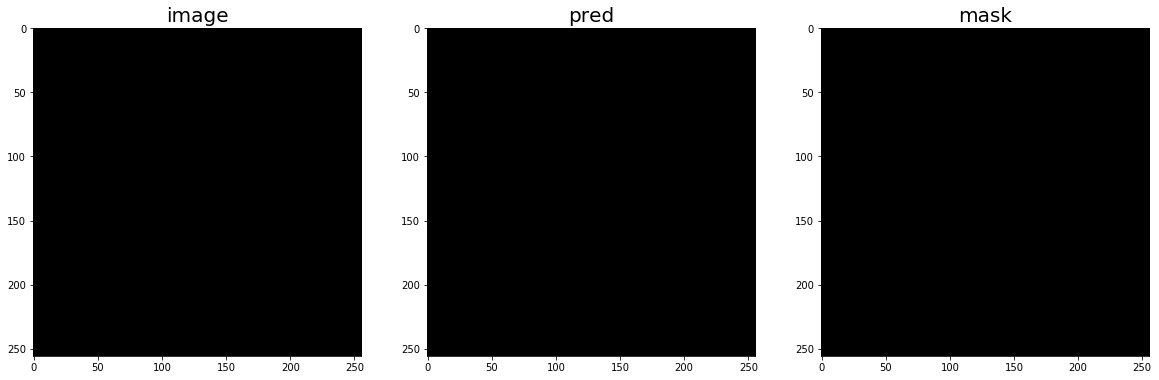

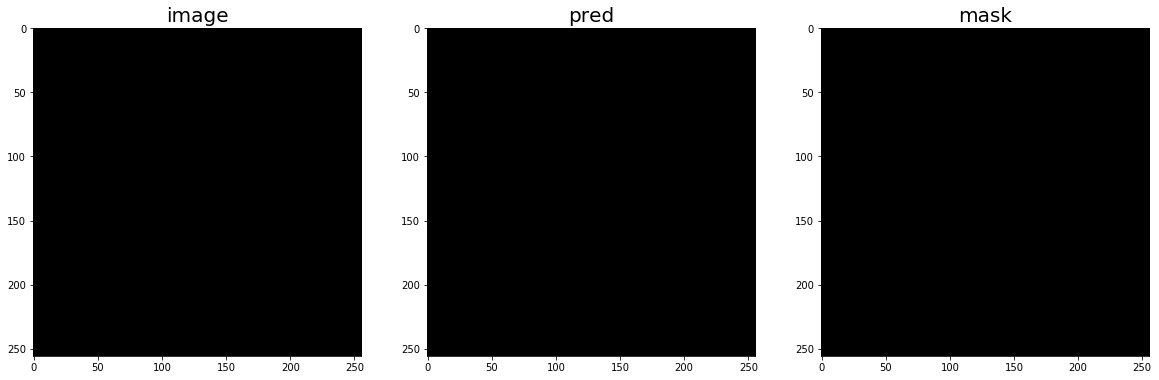

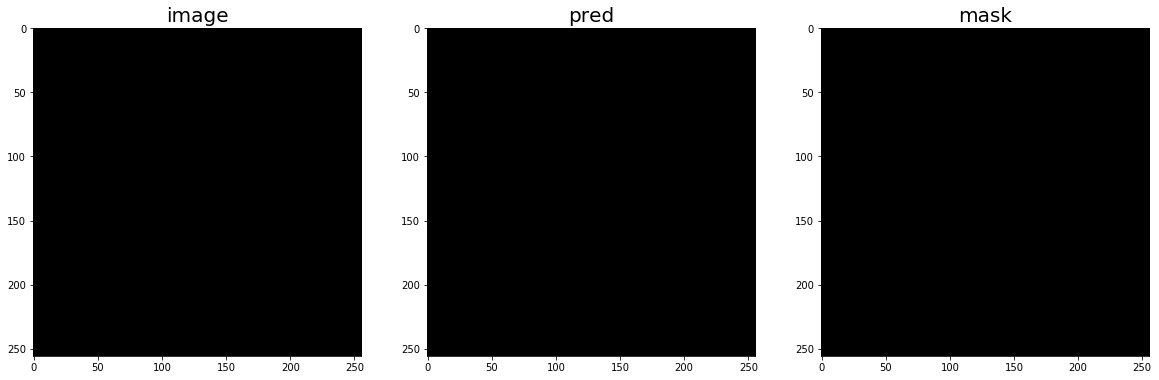

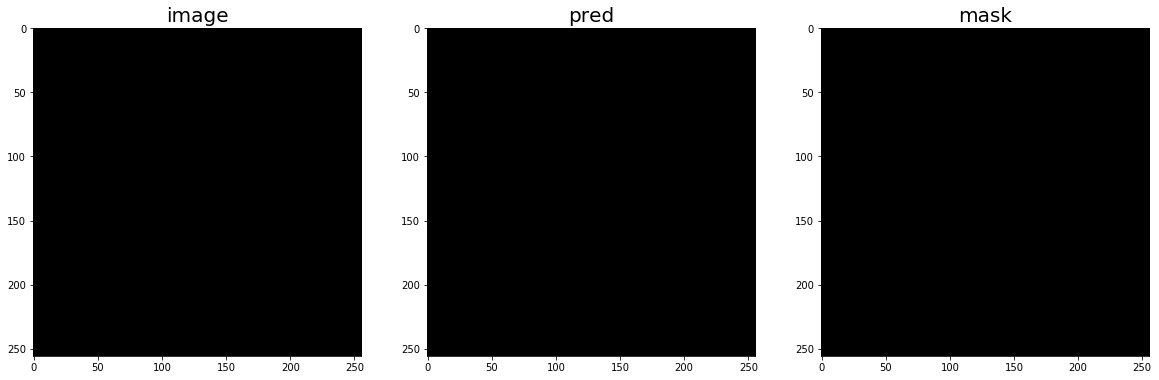

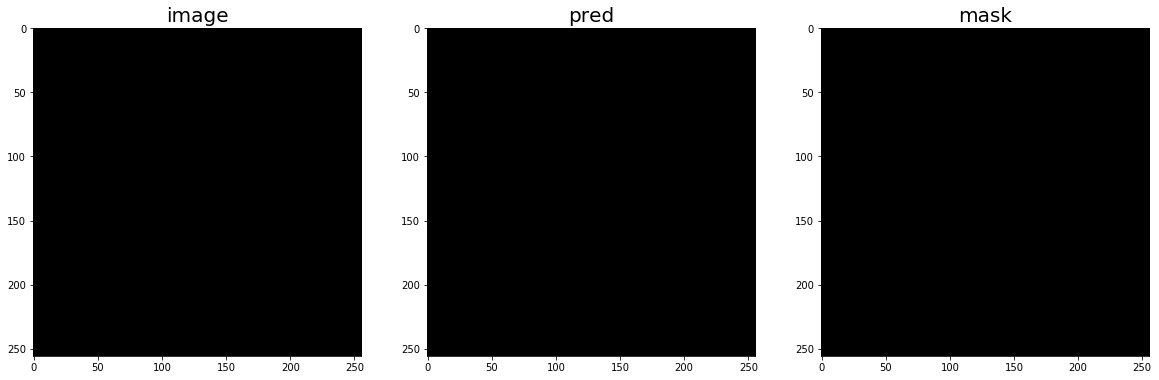

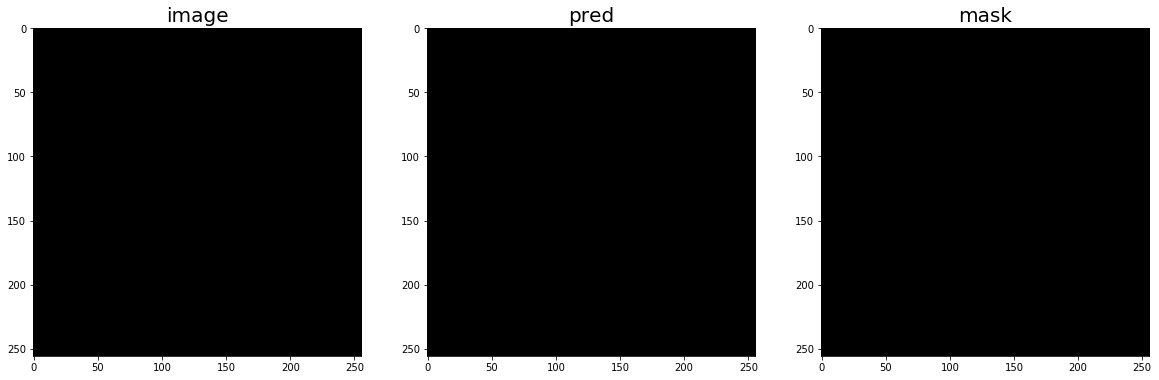

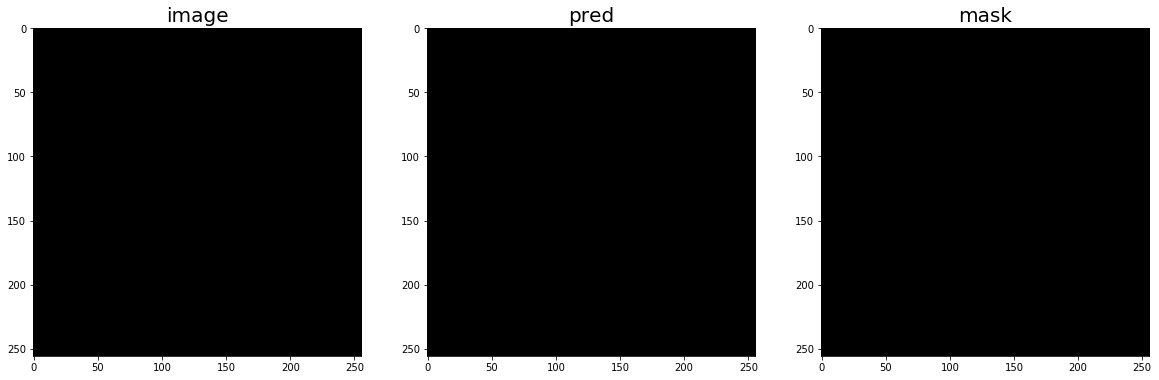

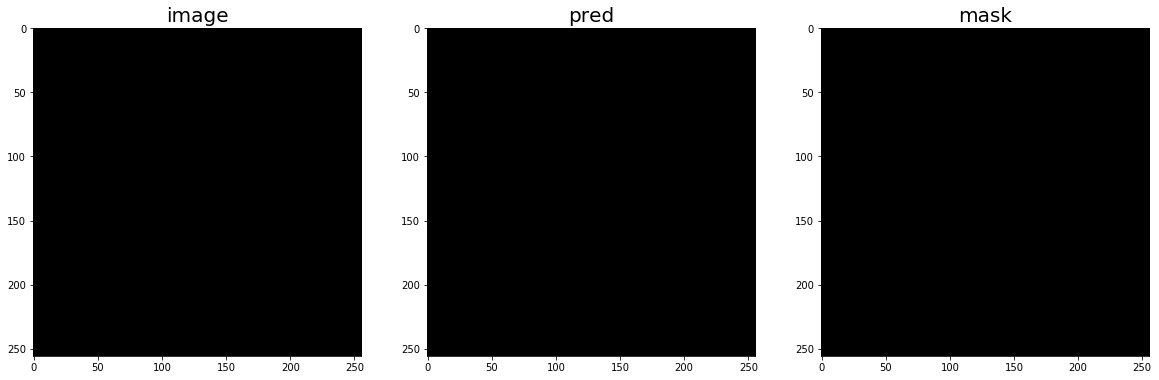

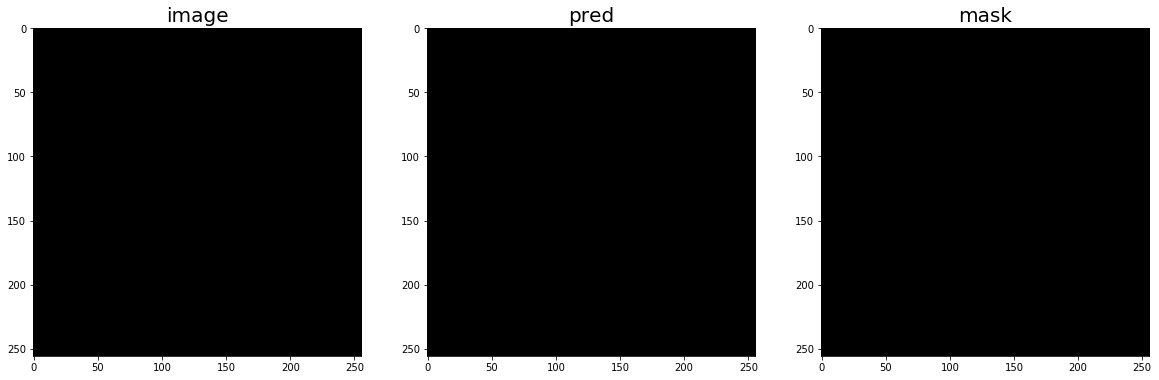

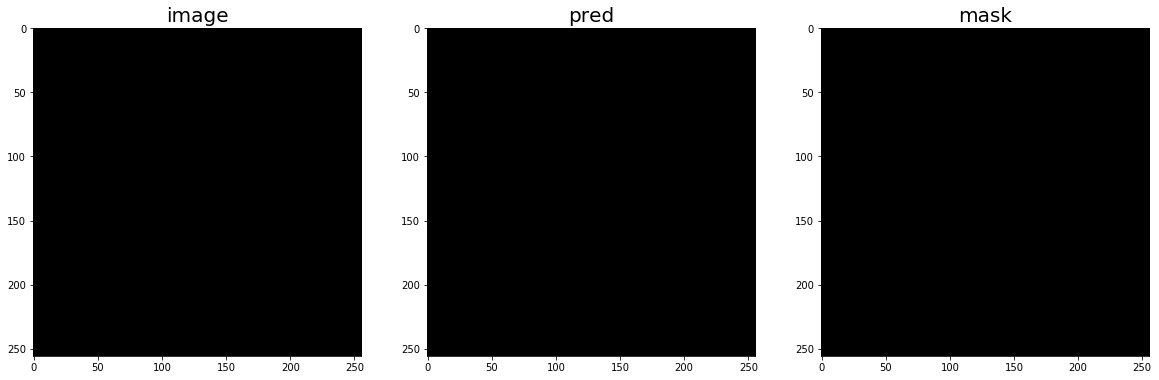

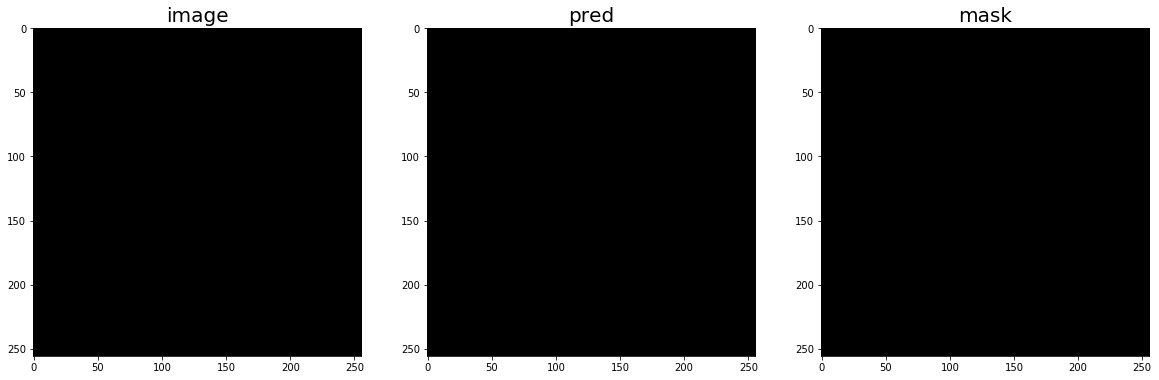

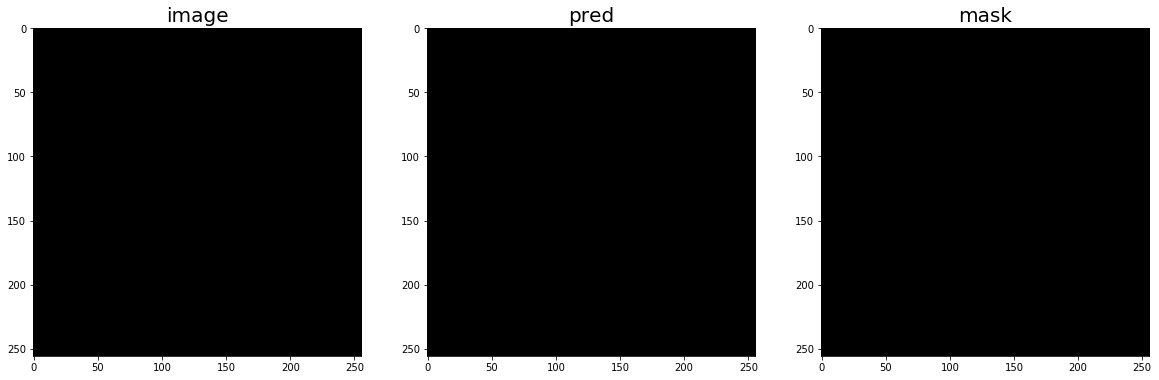

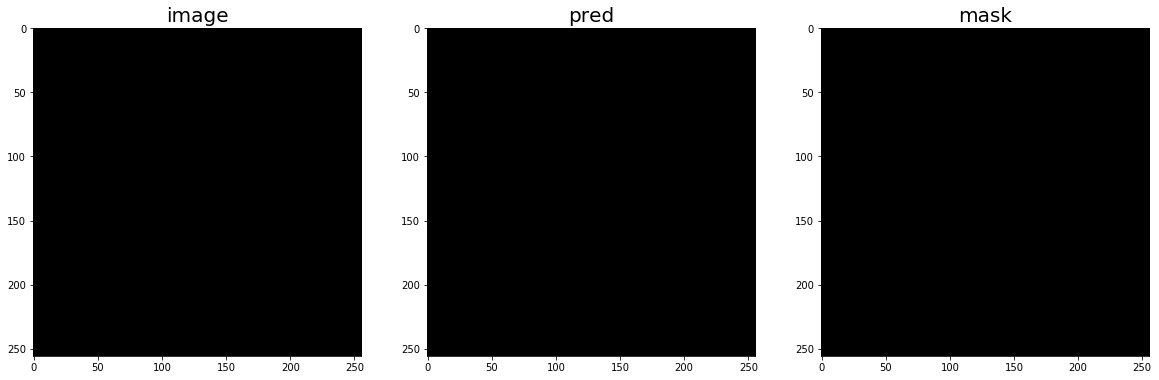

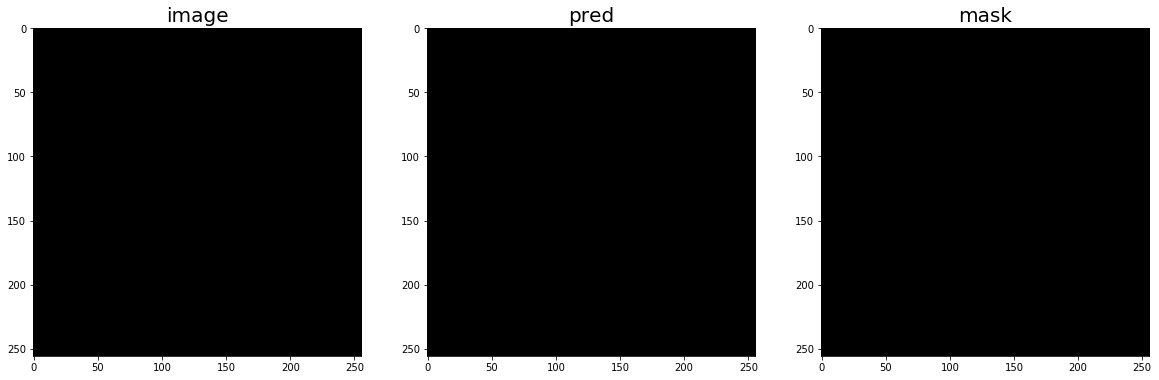

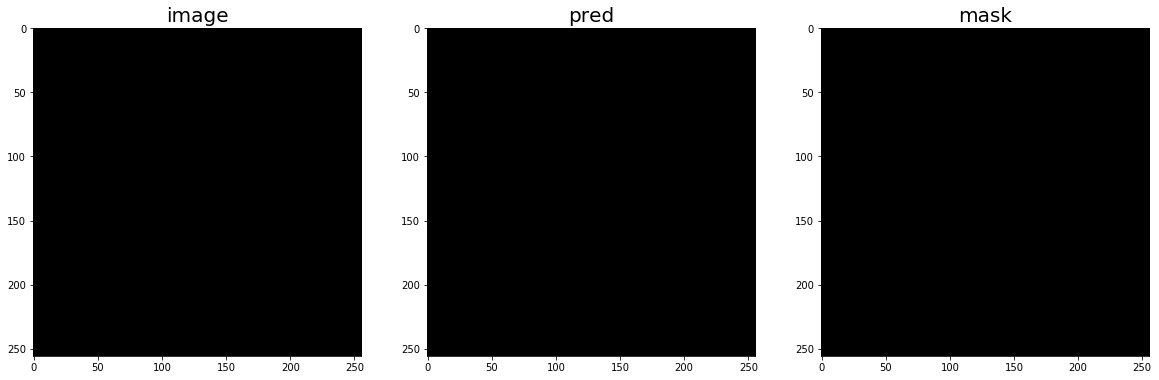

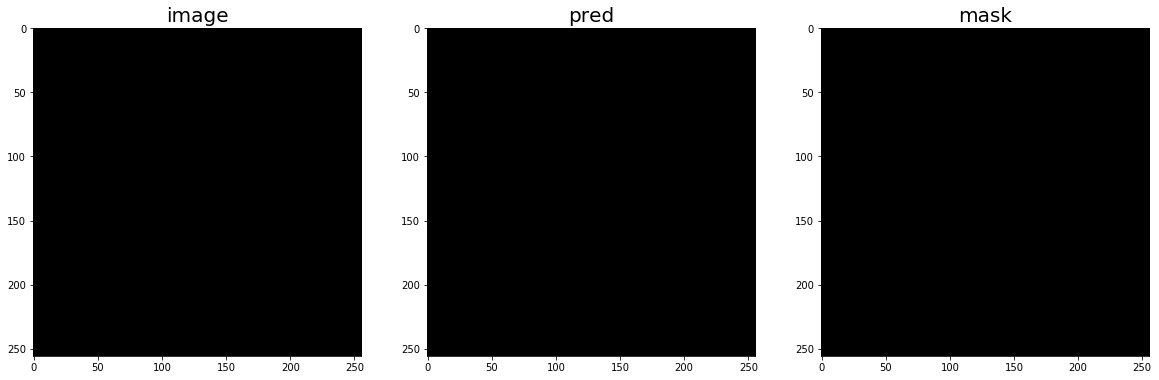

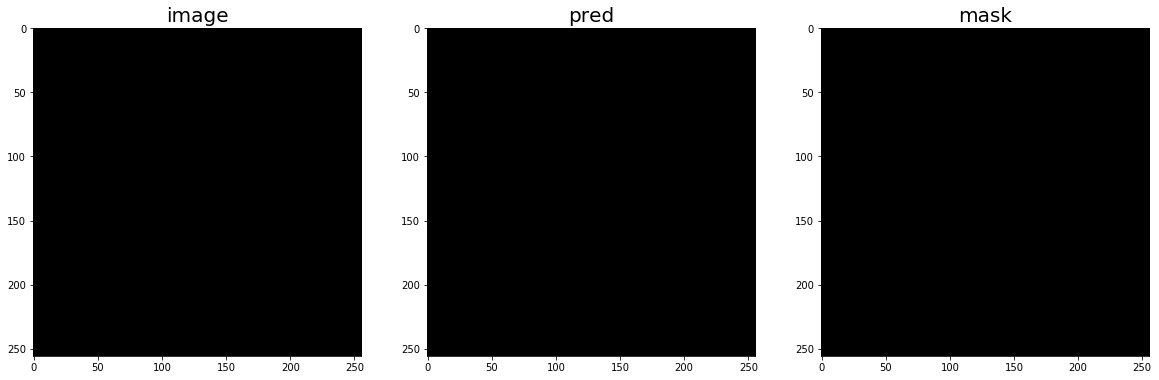

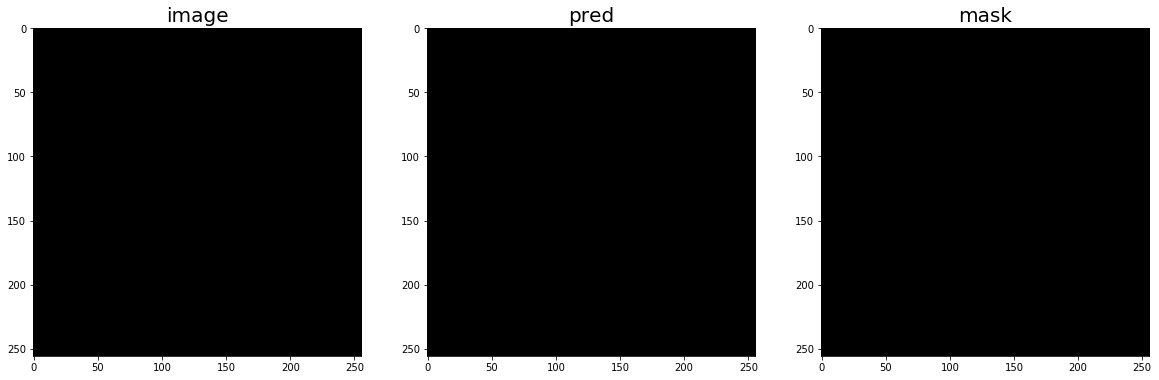

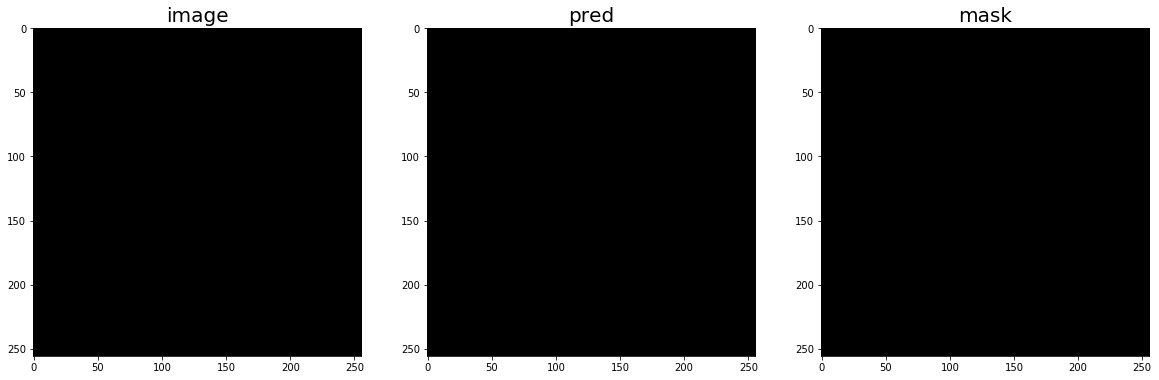

In [17]:
for i in range(image.shape[0]):
    plot_predictions(image[i], pred[i], mask[i])

## Prediction on Test Set

The following model was trained for 5 epochs with frozen layers at learning rate range from 5e-2. The layers were subsequently unfrozen and an additional 5 epochs were used to train the model at a learning rate of 3e-3. 

The input images into the CT ventricle segmentation model are skull stripped images. Please note that unlike the skull stripped images for training and validation, the **test skull stripped images were created by applying a brain-mask generated by a trained CT brain segmentation model** rather than using the contour that came with the RTstruct file.

In [22]:
learner.load("DL_Ventricles_TL_CT_5_epochs_5e-2_5_epochs_3e-3");

In [23]:
ts1 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test1_ds, bs=3)
ts2 = DataBunch.create(train_ds=train_ds, valid_ds=valid_ds, test_ds=test2_ds, bs=3)

In [24]:
images, preds, masks = predict(learner, ts1, validation=False)

In [25]:
for i in range(len(preds)):
    name = str(test1_mask[i]).split("/")[-1]
    pred = preds[i]
    np.save("/data/public/Segmentation_Dataset/CT_Dataset/test1/ventricle_pred/{name}".format(name=name), pred)
    

In [26]:
images, preds, masks = predict(learner, ts2, validation=False)

In [27]:
for i in range(len(preds)):
    name = str(test2_mask[i]).split("/")[-1]
    pred = preds[i]
    np.save("/data/public/Segmentation_Dataset/CT_Dataset/test2/ventricle_pred/{name}".format(name=name), pred)